### NOTEBOOK CONTENTS

-Looking at regional differences in air-sea flux values, and comparison with Evans 2011.


In [322]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [323]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [324]:
import matplotlib.pyplot as plt
import pickle

import netCDF4 as nc
import numpy as np
import scipy as sp
import warnings
warnings.filterwarnings('ignore')
import cmocean as cm
import glob
import sys
import mocsy
import gsw
%matplotlib inline
from salishsea_tools import grid_tools, viz_tools
from statsmodels.stats.weightstats import DescrStatsW
from math import log10, floor

Text(0.5, 1.0, 'regional mask')

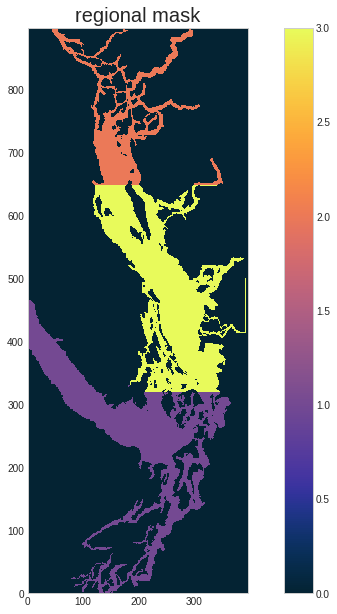

In [325]:
mesh = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')
tmask = mesh.variables['tmask'][0, 0, :, :]

mask = np.zeros_like(tmask)
mask[tmask>0] = 4

for y in range(0,898):
    for x in range(0,398):
        
        if  (x <185) & (y>220) & (y<500) & (tmask[y,x] >0) :
            mask[y,x] = 1
        if  (y >= 630) & (tmask[y,x] > 0): #changed from 550
            mask[y,x] = 2
        if (x> 185) & (y>320) & (y<630) & (tmask[y,x]>0):
            mask[y,x] = 3
        if (y>500) & (y<650) & (tmask[y,x]>0):
            mask[y,x] = 3

mask[mask == 4] = 1
pickle.dump(mask, open("reg_mask.pkl", 'wb'))


reg_mask = pickle.load(open('./reg_mask.pkl', 'rb'))  

fact = 0.65
fig, ax = plt.subplots(1, 1, figsize=(20*fact, 16*fact))
viz_tools.set_aspect(ax)
mesh = ax.pcolormesh(reg_mask, cmap=cm.cm.thermal)
fig.colorbar(mesh)
plt.title('regional mask',fontsize=20)

# notes about conversions
#### CO2 flux is in mmol/m2/s
#### for each day convert it to mmol/m2/day - then add all the days to get mmol/m2/year
#### how many seconds in a day? 

        60 s/min * 60 min/h * 24h/ day = 86400
        
#### once we have mmol/m2/year we convert to grams of C in a mmol. 
#### how many grams of C in a mmol? 12.0107 * 10e-3, by definition. 

In [326]:
# f = open('/data/tjarniko/MEOPAR/analysis_tereza/notebooks/PI_CARBON_PAPER/MAIN_ANALYSIS/pkls/flux/BR3_flx.pkl', 'rb')
# BR_flx = pickle.load(f)  

# print(np.shape(BR_flx))

# for i in range(0,365):
#     BR_flx[i,:,0:20] = np.nan
#     BR_flx[i,878:898,:] = np.nan
    
# pickle.dump(BR_flx, open("./BR_flx_edges_cut.pkl", 'wb'))

In [327]:
f = open('./BR_flx_edges_cut.pkl', 'rb')
BR_flx = pickle.load(f)   
csize = pickle.load(open('../pkls/ASflux_cellsize.pkl', 'rb')) 


#1.11 is the factor that we had to multiply by - Asselin filter
BR_flx_mmol_m2_day = BR_flx * 86400 * 1.11


BR_flx_mmol_m2_yr = np.sum(BR_flx_mmol_m2_day, axis = 0)


BR_flx_gC_m2_yr = BR_flx_mmol_m2_yr*12.0107*1e-3
BR_flx_gC_m2_yr[BR_flx_gC_m2_yr>1e6]=np.nan
BR_flx_gC_m2_yr[BR_flx_gC_m2_yr==0]=np.nan




# ds_S:de_S,0:878,20:398];


In [328]:
print(np.nanmean(BR_flx_gC_m2_yr))

-7.700517772227652


#### CO2 FLUX - 3 panel plot

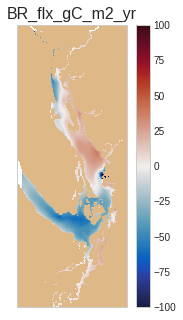

In [330]:
fact = 0.7
tf = 16


fig = plt.figure(figsize=(12*fact,6.5*fact))

ax1 = fig.add_subplot(1,3,1)
tplt = BR_flx_gC_m2_yr
viz_tools.set_aspect(ax1)
mesh = ax1.pcolormesh(tplt, cmap=cm.cm.balance, vmin=-100, vmax=100)
viz_tools.plot_land_mask(ax1, '/data/tjarniko/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc', color = 'burlywood')
ax1.set_title('BR_flx_gC_m2_yr', fontsize = tf)
plt.xticks([])
plt.yticks([])
plt.colorbar(mesh)

plt.tight_layout()

In [331]:
def round_sig(x, sig):
    return round(x, sig-int(floor(log10(abs(x))))-1)


#BR_avg = round_sig(np.mean(BR_flx_gC_m2_yr),4)

print('source (-) sink(+) g C/m2/yr stats for the three runs')
print('')
print('BR run:')
print('average:'+ str(round_sig(np.nanmean(BR_flx_gC_m2_yr),4)))
print('max:'+ str(round_sig(np.nanmax(BR_flx_gC_m2_yr),4)))
print('min:'+ str(round_sig(np.nanmin(BR_flx_gC_m2_yr),4)))


source (-) sink(+) g C/m2/yr stats for the three runs

BR run:
average:-7.701
max:38.61
min:-163.9


In [332]:
#5th is for the total
BR_regs = np.zeros(4)
for r in range(0,4):
    BR_regs[r] = np.nanmean(BR_flx_gC_m2_yr[mask == r+1])

    
BR_regs[3] = np.nanmean(BR_flx_gC_m2_yr)

print(BR_regs)


[-19.15852206  -4.55907125   2.0857054   -7.70051777]


Text(0.5, 1.0, 'C source(+) or sink(-) yearly mass balances')

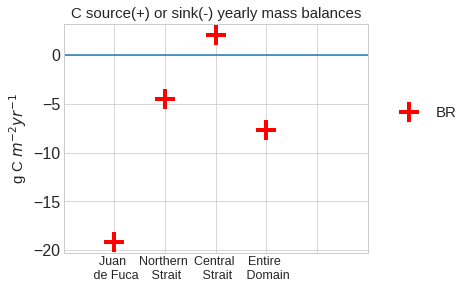

In [333]:
#1 is jdf, 4 is haro, 2 is n.strait 3 is s. strait
regs = [1,2,3,4]
fact = 0.6
tms = 20
tmew = 4
fig = plt.figure(figsize=(20*fact,7*fact))

ax1 = fig.add_subplot(1,2,1)
ax1.plot(regs,BR_regs,'+',mew=tmew, ms=tms,color='red', label = 'BR')
ax1.set_xlim([0,6])
plt.legend(bbox_to_anchor=(1.04,0.7), loc="upper left", fontsize = 15)
ax1.tick_params(labelsize=16)
ax1.set_ylabel('g C $m^{-2}yr^{-1}$',fontsize =15)
ax1.axhline(y=0)
ax1.set_xticklabels(['','Juan \n de Fuca','Northern \n Strait',\
                     'Central \n Strait','Entire \n Domain',''], fontsize = 12.5)
ax1.set_title('C source(+) or sink(-) yearly mass balances', fontsize = 15)



## Numbers summary

In [334]:
print('JDF            NS            CS   Entire_DOM')
print('BR')
print(BR_regs)

JDF            NS            CS   Entire_DOM
BR
[-19.15852206  -4.55907125   2.0857054   -7.70051777]


In [335]:

BR_nonan = BR_flx_gC_m2_yr[~np.isnan(BR_flx_gC_m2_yr)]




In [336]:
print(np.shape(BR_flx_gC_m2_yr))
print(np.shape(csize))

(898, 398)
(878, 378)


In [340]:
bin_propBR2, bins = np.histogram(BR_flx_gC_m2_yr[0:878,20:398], bins=28, range = [-100, 40], weights=csize)
bin_cent2 = bins + (bins[1]-bins[0])/2
bin_propBR3 = bin_propBR2/np.nansum(csize)
bin_cent_wh = bin_cent2[0:-1]
print(bin_cent_wh)

# print(bin_propBR2)
# print(np.sum(bin_propBR2))
# print(np.nansum(csize))

[-97.5 -92.5 -87.5 -82.5 -77.5 -72.5 -67.5 -62.5 -57.5 -52.5 -47.5 -42.5
 -37.5 -32.5 -27.5 -22.5 -17.5 -12.5  -7.5  -2.5   2.5   7.5  12.5  17.5
  22.5  27.5  32.5  37.5]


In [343]:
#make a manual histogramming code
step = 5
t_start = -100
t_end = 40
bin_starts = np.arange(t_start,t_end,step)
bin_ends = np.arange(t_start+step,t_end+step,step)
bin_centres = np.arange(t_start+step/2,t_end + step/2 ,step)
bin_prop = np.zeros_like(bin_centres)

def manual_hist(test_hist):
    for i in range(0,len(bin_starts)):
        obs_in_bin = test_hist[((test_hist>=bin_starts[i]) &\
                               (test_hist<bin_ends[i]))]

        bin_prop[i] = np.size(obs_in_bin)/np.size(test_hist)
    return bin_prop

bin_propBR = manual_hist(BR_nonan)
t_BR = np.copy(bin_propBR)
t_BR2 = t_BR/np.nansum(csize)

Text(0, 0.5, 'proportion of domain')

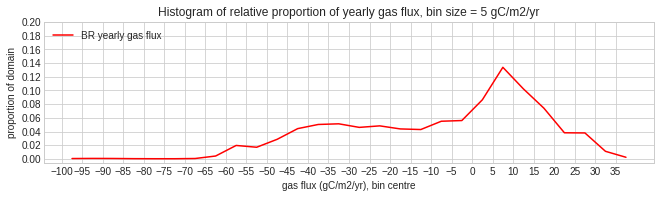

In [344]:
fact = 0.52
fig = plt.figure(figsize=(21*fact,5*fact))
lw = 2.5
ax1 = fig.add_subplot(1,1,1)
#ax1.plot(bin_centres,t_BR, color = 'red', label = 'BR yearly gas flux')
ax1.plot(bin_cent2[0:-1],bin_propBR3, color = 'r', label = 'BR yearly gas flux')




ax1.legend(loc = 'upper left')
ax1.set_title('Histogram of relative proportion of yearly gas flux, bin size = 5 gC/m2/yr')

w = ax1.set_xticks(np.arange(-100, 40, step=5))
w = ax1.set_yticks(np.arange(0, 0.22, step=0.02))
ax1.set_xlabel('gas flux (gC/m2/yr), bin centre')
ax1.set_ylabel('proportion of domain')

### Evans et al data - we need to multiply by -1 as his convention is to have CO2_into_ocean be (-), whereas for us CO2_outof_ocean is (-)
#### This pandas visualization already has the sign-switch incorporated


In [345]:
#infil = loadtxt('./pickles/Evans_seaair_numbers.csv')
#winter summer average
import pandas as pd
data = pd.read_csv('/data/tjarniko/MEOPAR/analysis_tereza/notebooks/PI_CARBON_PAPER/MAIN_ANALYSIS/pkls/Evans_seaair_numbers.csv')
data = data.drop("Unnamed: 4",axis = 1)
data = data.drop("Unnamed: 5",axis = 1)
data = data.drop("Unnamed: 6",axis = 1)
data = data.drop([12,13,14,15,16,17,18,19,20], axis = 0)
data = (-1)*data
data 

,measurement_mmol_m2_day,NSTRAIT_4,CSTRAIT_5,JDF_6
0,,-999.0,-5.5,-0.4
1,,-999.0,-9.7,-0.5
2,,-999.0,9.7,-0.0
3,,-999.0,-48.5,-4.1
4,,-15.6,17.5,-2.0
5,,-5.9,-10.4,-1.1
6,,-2.5,31.8,-0.0
7,,-28.8,-37.0,-4.9
8,,-7.1,-10.0,-28.4
9,,-13.1,-6.4,-41.1


In [346]:
#extract (1)*data manually and switch sign
NS_W_mean = np.nan; NS_W_std = np.nan;
NS_W_min = np.nan; NS_W_max = np.nan; 


NS_S_mean = (1)*data['NSTRAIT_4'][4]; NS_S_std = (1)*data['NSTRAIT_4'][5] ;
NS_S_min = (1)*data['NSTRAIT_4'][6]; NS_S_max = (1)*data['NSTRAIT_4'][7] ;
NS_A_mean = (1)*data['NSTRAIT_4'][8]; NS_A_std = (1)*data['NSTRAIT_4'][9] ;
NS_A_min = (1)*data['NSTRAIT_4'][10]; NS_A_max = (1)*data['NSTRAIT_4'][11] ;

CS_W_mean = (1)*data['CSTRAIT_5'][0]; CS_W_std = (1)*data['CSTRAIT_5'][1] ;
CS_W_min = (1)*data['CSTRAIT_5'][2]; CS_W_max = (1)*data['CSTRAIT_5'][3] ; 
CS_S_mean = (1)*data['CSTRAIT_5'][4]; CS_S_std = (1)*data['CSTRAIT_5'][5] ;
CS_S_min = (1)*data['CSTRAIT_5'][6]; CS_S_max = (1)*data['CSTRAIT_5'][7] ;
CS_A_mean = (1)*data['CSTRAIT_5'][8]; CS_A_std = (1)*data['CSTRAIT_5'][9] ;
CS_A_min = (1)*data['CSTRAIT_5'][10]; CS_A_max = (1)*data['CSTRAIT_5'][11] ;

JDF_W_mean = (1)*data['JDF_6'][0]; JDF_W_std = (1)*data['JDF_6'][1] ;
JDF_W_min = (1)*data['JDF_6'][2]; JDF_W_max = (1)*data['JDF_6'][3] ; 
JDF_S_mean = (1)*data['JDF_6'][4]; JDF_S_std = (1)*data['JDF_6'][5] ;
JDF_S_min = (1)*data['JDF_6'][6]; JDF_S_max = (1)*data['JDF_6'][7] ;
JDF_A_mean = (1)*data['JDF_6'][8]; JDF_A_std = (1)*data['JDF_6'][9] ;
JDF_A_min = (1)*data['JDF_6'][10]; JDF_A_max = (1)*data['JDF_6'][11] ;

D_SUM = 90
D_WINT = 90
D_AUT = 91

#calculating summer, winter, and autumn mean, with the assumption that a spring mean flux is 0 
JDF_ANN_MEAN = (D_SUM/365)*JDF_S_mean + (D_WINT/365)*JDF_W_mean + (D_AUT/365) * JDF_A_mean
CS_ANN_MEAN = (D_SUM/365)*CS_S_mean + (D_WINT/365)*CS_W_mean + (D_AUT/365) * CS_A_mean

#### conversion gC/m2/yr to mmolC/m2/s:

from gC/m2/yr to gC/m2/s:

gC/m2/yr * (day/86400 s) (year/365 day)

from gC/m2/s to mmol/m2/s

1 mmol/ (12.0107 * 10e-3 g)

so multiply by (1/86400) * (1/365) * (1 / 12.0107 * 10e-3) 

#### conversion gC/m2/yr to mmolC/m2/day:

from gC/m2/yr to gC/m2/s:

gC/m2/yr *  (year/365 day)

from gC/m2/s to mmol/m2/s

1 mmol/ (12.0107 * 10e-3 g)

so multiply by (1/86400) * (1/365) * (1 / 12.0107 * 10e-3) 

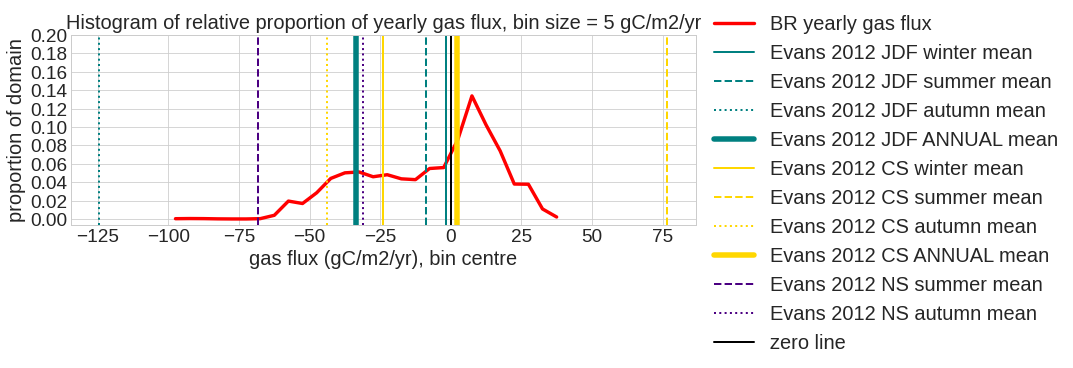

In [347]:
corfact = 1/(1 * (1/365) * (1 / 12.0107e-3))

fact = 0.7
fig = plt.figure(figsize=(16*fact,5*fact))
lw = 2.5
ax1 = fig.add_subplot(1,1,1)
#ax1.plot(bin_centres,t_LA, color = 'dimgrey', lw = 3.4, label = 'LA yearly gas flux')
#ax1.plot(bin_centres,t_PI, color = 'cornflowerblue', lw = 3.4,label = 'PI yearly gas flux')
#ax1.plot(bin_centres,t_BR, color = 'red', lw = 3.4,label = 'BR yearly gas flux')
ax1.plot(bin_cent2[0:-1],bin_propBR3, color = 'red', lw = 3.4, label = 'BR yearly gas flux')

ax1.axvline(JDF_W_mean*corfact, color = 'teal', lw = 2, label = 'Evans 2012 JDF winter mean')
ax1.axvline(JDF_S_mean*corfact, color = 'teal', linestyle = '--' , lw = 2, label = 'Evans 2012 JDF summer mean')
ax1.axvline(JDF_A_mean*corfact, color = 'teal', linestyle = ':', lw = 2, label = 'Evans 2012 JDF autumn mean')
ax1.axvline(JDF_ANN_MEAN*corfact, color = 'teal', lw = 5.5, label = 'Evans 2012 JDF ANNUAL mean')


ax1.axvline(CS_W_mean*corfact, color = 'gold', lw = 2, label = 'Evans 2012 CS winter mean')
ax1.axvline(CS_S_mean*corfact, color = 'gold', linestyle = '--' , lw = 2, label = 'Evans 2012 CS summer mean')
ax1.axvline(CS_A_mean*corfact, color = 'gold', linestyle = ':', lw = 2, label = 'Evans 2012 CS autumn mean')
ax1.axvline(CS_ANN_MEAN*corfact, color = 'gold', linestyle = '-', lw = 5.5, label = 'Evans 2012 CS ANNUAL mean')

#ax1.axvline(NS_W_mean*corfact, color = 'indigo', lw = 2, label = 'NS winter mean')
ax1.axvline(NS_S_mean*corfact, color = 'indigo', linestyle = '--' , lw = 2, label = 'Evans 2012 NS summer mean')
ax1.axvline(NS_A_mean*corfact, color = 'indigo', linestyle = ':', lw = 2, label = 'Evans 2012 NS autumn mean')

ax1.axvline(0*corfact, color = 'black', linestyle = '-', lw = 2, label = 'zero line')

#
# ax1.axvline(88, color = 'lightsteelblue', lw = 2, label = 'Hales 2005, Oregon Coast')
# ax1.axvline(-3.1, color = 'teal', lw = 2, label = 'Evans 2011, Oregon Coast (+/ 82...)')
# ax1.axvline(7.9, color = 'crimson', lw = 2, label = 'Hales 2012, 22-50N, within 370 km offshore')
# ax1.axvline(26, color = 'lime', lw = 2, label = 'Evans 2012 BC coast')
# ax1.axvline(18, color = 'tan', lw = 2, label = 'Evans and Mathis 2013 Gulf of Alaska')

ax1.legend(bbox_to_anchor=[1.00, 1.2], fontsize =20)
ax1.set_title('Histogram of relative proportion of yearly gas flux, bin size = 5 gC/m2/yr', fontsize =20)

#w = ax1.set_xticks(np.arange(-100, 40, step=5))
w = ax1.set_yticks(np.arange(0, 0.22, step=0.02))
ax1.set_xlabel('gas flux (gC/m2/yr), bin centre', fontsize =20 )
ax1.set_ylabel('proportion of domain', fontsize =20)
ax1.tick_params(axis='both', which='major', labelsize=19)
ax1.tick_params(axis='both', which='minor', labelsize=19)

## subset different regions of the domain for analysis; define season by evans et al


In [354]:
yearmask = np.zeros([365,898,398])

for i in range(0,365):
    yearmask[i,:,:] = mask

In [349]:
print('1 is jdf, 4 is haro, 2 is n.strait 3 is s. strait (c. strait)')

# Season definition: Winter as January 1 to March 31, spring as April 1 to
# June 30, summer as July 1 to September 30, and autumn as October
# 1 to December 31. (as used in Evans 2011). 

#jdf_haro
BR_flx_JH = np.copy(BR_flx)
BR_flx_JH[BR_flx>1e10] = np.nan
BR_flx_JH[yearmask==2] = np.nan
BR_flx_JH[yearmask==3] = np.nan
#convert from mmol/m2/s to mmol/m2/day with convfactor 86400 s/day
BR_flx_JH = BR_flx_JH*86400


#central_strait
BR_flx_CS = np.copy(BR_flx)
BR_flx_CS[BR_flx>1e10] = np.nan
BR_flx_CS[yearmask!=3] = np.nan
#convert from mmol/m2/s to mmol/m2/day with convfactor 86400 s/day
BR_flx_CS = BR_flx_CS*86400

#northern_strait
BR_flx_NS = np.copy(BR_flx)
BR_flx_NS[BR_flx>1e10] = np.nan
BR_flx_NS[yearmask!=2] = np.nan
#convert from mmol/m2/s to mmol/m2/day with convfactor 86400 s/day
BR_flx_NS = BR_flx_NS*86400



1 is jdf, 4 is haro, 2 is n.strait 3 is s. strait (c. strait)


In [350]:
# starts and ends of things
# Season definition: Winter as January 1 to March 31, spring as April 1 to
# June 30, summer as July 1 to September 30, and autumn as October
# 1 to December 31. (as used in Evans 2011). 
# S is summer not spring
ds_S = 182-1
de_S = 273-1
ds_W = 1-1
de_W = 90-1
ds_A = 274-1
de_A = 365-1

## extract the correct seasons from the full dataset and do weighted stats- mean, min, max

In [351]:
array = np.array([1,2,1,5000,1,2,1,3])
weights = np.ones_like(array)
weights[3] = 100

weighted_stats = DescrStatsW(array, weights=weights, ddof=0)

weighted_stats.mean
csize = pickle.load(open('../pkls/ASflux_cellsize.pkl', 'rb')) 

BR_JH_S = BR_flx_JH[ds_S:de_S,0:878,20:398];
weight = np.zeros_like(BR_JH_S)
days = np.shape(BR_JH_S); days = days[0]
print(days)
for i in range(0,days):
    weight[i,:] = csize
BR_JH_S[np.isnan(BR_JH_S) ] = 0
weighted_stats = DescrStatsW(BR_JH_S.ravel(), weights=weight.ravel(), ddof=0)
BR_JH_S_avg = weighted_stats.mean; BR_JH_S_std = weighted_stats.std
BR_JH_S_max = np.nanmax(BR_JH_S); BR_JH_S_min = np.nanmin(BR_JH_S);

BR_JH_A = BR_flx_JH[ds_A:de_A,0:878,20:398];
weight = np.zeros_like(BR_JH_A)
days = np.shape(BR_JH_A); days = days[0]
print(days)
for i in range(0,days):
    weight[i,:] = csize
BR_JH_A[np.isnan(BR_JH_A) ] = 0
weighted_stats = DescrStatsW(BR_JH_A.ravel(), weights=weight.ravel(), ddof=0)
BR_JH_A_avg = weighted_stats.mean; BR_JH_A_std = weighted_stats.std
BR_JH_A_avg = weighted_stats.mean; BR_JH_A_std = weighted_stats.std
BR_JH_A_max = np.nanmax(BR_JH_A); BR_JH_A_min = np.nanmin(BR_JH_A);

BR_JH_W = BR_flx_JH[ds_W:de_W,0:878,20:398];
weight = np.zeros_like(BR_JH_W)
days = np.shape(BR_JH_W); days = days[0]
print(days)
for i in range(0,days):
    weight[i,:] = csize
BR_JH_W[np.isnan(BR_JH_W) ] = 0
weighted_stats = DescrStatsW(BR_JH_W.ravel(), weights=weight.ravel(), ddof=0)
BR_JH_W_avg = weighted_stats.mean; BR_JH_W_std = weighted_stats.std
BR_JH_W_avg = weighted_stats.mean; BR_JH_W_std = weighted_stats.std
BR_JH_W_max = np.nanmax(BR_JH_W); BR_JH_W_min = np.nanmin(BR_JH_W);




91
91
89


In [352]:
BR_CS_S = BR_flx_CS[ds_S:de_S,0:878,20:398];
weight = np.zeros_like(BR_CS_S)
days = np.shape(BR_CS_S); days = days[0]
print(days)
for i in range(0,days):
    weight[i,:] = csize
BR_CS_S[np.isnan(BR_CS_S) ] = 0
weighted_stats = DescrStatsW(BR_CS_S.ravel(), weights=weight.ravel(), ddof=0)
BR_CS_S_avg = weighted_stats.mean; BR_CS_S_std = weighted_stats.std
BR_CS_S_max = np.nanmax(BR_CS_S); BR_CS_S_min = np.nanmin(BR_CS_S);

BR_CS_A = BR_flx_CS[ds_A:de_A,0:878,20:398];
weight = np.zeros_like(BR_CS_A)
days = np.shape(BR_CS_A); days = days[0]
print(days)
for i in range(0,days):
    weight[i,:] = csize
BR_CS_A[np.isnan(BR_CS_A) ] = 0
weighted_stats = DescrStatsW(BR_CS_A.ravel(), weights=weight.ravel(), ddof=0)
BR_CS_A_avg = weighted_stats.mean; BR_CS_A_std = weighted_stats.std
BR_CS_A_avg = weighted_stats.mean; BR_CS_A_std = weighted_stats.std
BR_CS_A_max = np.nanmax(BR_CS_A); BR_CS_A_min = np.nanmin(BR_CS_A);

BR_CS_W = BR_flx_CS[ds_W:de_W,0:878,20:398];
weight = np.zeros_like(BR_CS_W)
days = np.shape(BR_CS_W); days = days[0]
print(days)
for i in range(0,days):
    weight[i,:] = csize
BR_CS_W[np.isnan(BR_CS_W) ] = 0
weighted_stats = DescrStatsW(BR_CS_W.ravel(), weights=weight.ravel(), ddof=0)
BR_CS_W_avg = weighted_stats.mean; BR_CS_W_std = weighted_stats.std
BR_CS_W_avg = weighted_stats.mean; BR_CS_W_std = weighted_stats.std
BR_CS_W_max = np.nanmax(BR_CS_W); BR_CS_W_min = np.nanmin(BR_CS_W);


91
91
89


In [353]:
BR_NS_S = BR_flx_NS[ds_S:de_S,0:878,20:398];
weight = np.zeros_like(BR_NS_S)
days = np.shape(BR_NS_S); days = days[0]
print(days)
for i in range(0,days):
    weight[i,:] = csize
BR_NS_S[np.isnan(BR_NS_S) ] = 0
weighted_stats = DescrStatsW(BR_NS_S.ravel(), weights=weight.ravel(), ddof=0)
BR_NS_S_avg = weighted_stats.mean; BR_NS_S_std = weighted_stats.std
BR_NS_S_max = np.nanmax(BR_NS_S); BR_NS_S_min = np.nanmin(BR_NS_S);

BR_NS_A = BR_flx_NS[ds_A:de_A,0:878,20:398];
weight = np.zeros_like(BR_NS_A)
days = np.shape(BR_NS_A); days = days[0]
print(days)
for i in range(0,days):
    weight[i,:] = csize
BR_NS_A[np.isnan(BR_NS_A) ] = 0
weighted_stats = DescrStatsW(BR_NS_A.ravel(), weights=weight.ravel(), ddof=0)
BR_NS_A_avg = weighted_stats.mean; BR_NS_A_std = weighted_stats.std
BR_NS_A_avg = weighted_stats.mean; BR_NS_A_std = weighted_stats.std
BR_NS_A_max = np.nanmax(BR_NS_A); BR_NS_A_min = np.nanmin(BR_NS_A);

BR_NS_W = BR_flx_NS[ds_W:de_W,0:878,20:398];
weight = np.zeros_like(BR_NS_W)
days = np.shape(BR_NS_W); days = days[0]
print(days)
for i in range(0,days):
    weight[i,:] = csize
BR_NS_W[np.isnan(BR_NS_W) ] = 0
weighted_stats = DescrStatsW(BR_NS_W.ravel(), weights=weight.ravel(), ddof=0)
BR_NS_W_avg = weighted_stats.mean; BR_NS_W_std = weighted_stats.std
BR_NS_W_avg = weighted_stats.mean; BR_NS_W_std = weighted_stats.std
BR_NS_W_max = np.nanmax(BR_NS_W); BR_NS_W_min = np.nanmin(BR_NS_W);


91
91
89


## weighted histograms, 3 regions, 3 seasons

In [ ]:
bin_cent2 = bins + (bins[1]-bins[0])/2
bin_cent_wh = bin_cent2[0:-1]
print(bin_cent_wh)

In [383]:
tin = BR_flx_JH[ds_S:de_S,0:878,20:398]

# mask_BR_S = np.copy(yearmask)
# mask_BR_S[yearmask_BR!=1] = 0
# mask_BR_S[yearmask_BR!=1]

weight = np.zeros_like(tin); days = np.shape(tin); days = days[0]; print(days)
for i in range(0,days):
    weight[i,:] = csize
weight[np.isnan(tin)] = np.nan
BR_JH_S, bins = np.histogram(tin, bins=28, range = [-100, 40], weights=weight)
bin_cent2 = bins + (bins[1]-bins[0])/2
bin_cent_wh = bin_cent2[0:-1]
print(bin_cent_wh)
print(np.sum(BR_JH_S/np.sum(BR_JH_S)*(bin_cent_wh)))


tin = BR_flx_CS[ds_S:de_S,0:878,20:398]
weight = np.zeros_like(tin); days = np.shape(tin); days = days[0]; print(days)
for i in range(0,days):
    weight[i,:] = csize
BR_CS_S, bins = np.histogram(tin, bins=28, range = [-100, 40], weights=weight)
print(np.sum(BR_CS_S/np.sum(BR_CS_S)*(bin_cent_wh)))

tin = BR_flx_NS[ds_S:de_S,0:878,20:398]
weight = np.zeros_like(tin); days = np.shape(tin); days = days[0]; print(days)
for i in range(0,days):
    weight[i,:] = csize
BR_NS_S, bins = np.histogram(tin, bins=28, range = [-100, 40], weights=weight)


91
[-97.5 -92.5 -87.5 -82.5 -77.5 -72.5 -67.5 -62.5 -57.5 -52.5 -47.5 -42.5
 -37.5 -32.5 -27.5 -22.5 -17.5 -12.5  -7.5  -2.5   2.5   7.5  12.5  17.5
  22.5  27.5  32.5  37.5]
-1.7667217023835349
91
3.4827630586494065
91


In [382]:
print(BR_CS_S_avg)

1.9778117017097487


In [361]:
tin = BR_flx_JH[ds_W:de_W,0:878,20:398]
weight = np.zeros_like(tin); days = np.shape(tin); days = days[0]; print(days)
for i in range(0,days):
    weight[i,:] = csize
BR_JH_W, bins = np.histogram(tin, bins=28, range = [-100, 40], weights=weight)

tin = BR_flx_CS[ds_W:de_W,0:878,20:398]
weight = np.zeros_like(tin); days = np.shape(tin); days = days[0]; print(days)
for i in range(0,days):
    weight[i,:] = csize
BR_CS_W, bins = np.histogram(tin, bins=28, range = [-100, 40], weights=weight)

tin = BR_flx_NS[ds_W:de_W,0:878,20:398]
weight = np.zeros_like(tin); days = np.shape(tin); days = days[0]; print(days)
for i in range(0,days):
    weight[i,:] = csize
BR_NS_W, bins = np.histogram(tin, bins=28, range = [-100, 40], weights=weight)


89
89
89


In [362]:
tin = BR_flx_JH[ds_A:de_A,0:878,20:398]
weight = np.zeros_like(tin); days = np.shape(tin); days = days[0]; print(days)
for i in range(0,days):
    weight[i,:] = csize
BR_JH_A, bins = np.histogram(tin, bins=28, range = [-100, 40], weights=weight)

tin = BR_flx_CS[ds_A:de_A,0:878,20:398]
weight = np.zeros_like(tin); days = np.shape(tin); days = days[0]; print(days)
for i in range(0,days):
    weight[i,:] = csize
BR_CS_A, bins = np.histogram(tin, bins=28, range = [-100, 40], weights=weight)

tin = BR_flx_NS[ds_A:de_A,0:878,20:398]
weight = np.zeros_like(tin); days = np.shape(tin); days = days[0]; print(days)
for i in range(0,days):
    weight[i,:] = csize
BR_NS_A, bins = np.histogram(tin, bins=28, range = [-100, 40], weights=weight)


91
91
91


[-97.5 -92.5 -87.5 -82.5 -77.5 -72.5 -67.5 -62.5 -57.5 -52.5 -47.5 -42.5
 -37.5 -32.5 -27.5 -22.5 -17.5 -12.5  -7.5  -2.5   2.5   7.5  12.5  17.5
  22.5  27.5  32.5  37.5]


In [359]:
# #BR histograms
# #BR_JH_S = BR_flx_JH[ds_S:de_S,:,:]; BR_JH_S[BR_JH_S==0] = np.nan; BR_JH_S_nn = BR_JH_S[~np.isnan(BR_JH_S)];

# tin = BR_flx_JH[ds_S:de_S,0:878,20:398]
# weight = np.zeros_like(tin); days = np.shape(tin); days = days[0]; print(days)
# for i in range(0,days):
#     weight[i,:] = csize
# BR_JH_S, bins = np.histogram(tin, bins=28, range = [-100, 40], weights=weight)

# tin = BR_flx_CS[ds_S:de_S,0:878,20:398]
# weight = np.zeros_like(tin); days = np.shape(tin); days = days[0]; print(days)
# for i in range(0,days):
#     weight[i,:] = csize
# BR_CS_S, bins = np.histogram(tin, bins=28, range = [-100, 40], weights=weight)

# tin = BR_flx_NS[ds_S:de_S,0:878,20:398]
# weight = np.zeros_like(tin); days = np.shape(tin); days = days[0]; print(days)
# for i in range(0,days):
#     weight[i,:] = csize
# BR_NS_S, bins = np.histogram(tin, bins=28, range = [-100, 40], weights=weight)

# # bp_BR_JH_S = manual_hist(BR_JH_S_nn); t_bp_BR_JH_S = np.copy(bp_BR_JH_S);
# # BR_CS_S = BR_flx_CS[ds_S:de_S,:,:]; BR_CS_S[BR_CS_S==0] = np.nan; BR_CS_S_nn = BR_CS_S[~np.isnan(BR_CS_S)];
# # bp_BR_CS_S = manual_hist(BR_CS_S_nn); t_bp_BR_CS_S = np.copy(bp_BR_CS_S);
# # BR_NS_S = BR_flx_NS[ds_S:de_S,:,:]; BR_NS_S[BR_NS_S==0] = np.nan; BR_NS_S_nn = BR_NS_S[~np.isnan(BR_NS_S)];
# # bp_BR_NS_S = manual_hist(BR_NS_S_nn); t_bp_BR_NS_S = np.copy(bp_BR_NS_S)

# # ##
# # #BR histograms
# # BR_JH_A = BR_flx_JH[ds_A:de_A,:,:]; BR_JH_A[BR_JH_A==0] = np.nan; BR_JH_A_nn = BR_JH_A[~np.isnan(BR_JH_A)];
# # bp_BR_JH_A = manual_hist(BR_JH_A_nn); t_bp_BR_JH_A = np.copy(bp_BR_JH_A);
# # BR_CS_A = BR_flx_CS[ds_A:de_A,:,:]; BR_CS_A[BR_CS_A==0] = np.nan; BR_CS_A_nn = BR_CS_A[~np.isnan(BR_CS_A)];
# # bp_BR_CS_A = manual_hist(BR_CS_A_nn); t_bp_BR_CS_A = np.copy(bp_BR_CS_A);
# # BR_NS_A = BR_flx_NS[ds_A:de_A,:,:]; BR_NS_A[BR_NS_A==0] = np.nan; BR_NS_A_nn = BR_NS_A[~np.isnan(BR_NS_A)];
# # bp_BR_NS_A = manual_hist(BR_NS_A_nn); t_bp_BR_NS_A = np.copy(bp_BR_NS_A)

# # ##
# # #BR histograms
# # BR_JH_W = BR_flx_JH[ds_W:de_W,:,:]; BR_JH_W[BR_JH_W==0] = np.nan; BR_JH_W_nn = BR_JH_W[~np.isnan(BR_JH_W)];
# # bp_BR_JH_W = manual_hist(BR_JH_W_nn); t_bp_BR_JH_W = np.copy(bp_BR_JH_W);
# # BR_CS_W = BR_flx_CS[ds_W:de_W,:,:]; BR_CS_W[BR_CS_W==0] = np.nan; BR_CS_W_nn = BR_CS_W[~np.isnan(BR_CS_W)];
# # bp_BR_CS_W = manual_hist(BR_CS_W_nn); t_bp_BR_CS_W = np.copy(bp_BR_CS_W);
# # BR_NS_W = BR_flx_NS[ds_W:de_W,:,:]; BR_NS_W[BR_NS_W==0] = np.nan; BR_NS_W_nn = BR_NS_W[~np.isnan(BR_NS_W)];
# # bp_BR_NS_W = manual_hist(BR_NS_W_nn); t_bp_BR_NS_W = np.copy(bp_BR_NS_W)


91


## A schematic of seasonal statistics of air-sea flux (Evans et al 2012)
#### negative values are out-of-ocean here
#### x axis has not been adjusted, to allow natural range to be expressed

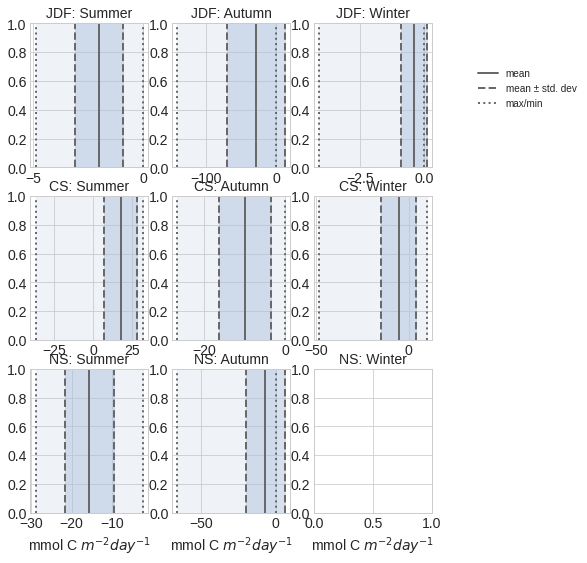

In [364]:


#convert mmol/m2/s to mmol/m2/day

#1 is jdf, 4 is haro, 2 is n.strait 3 is s. strait

fact = 0.6
tms = 20
tmew = 4
tsz = 14
trot = 0
tcol = 'dimgrey'
tcol2 = 'lightsteelblue'
fig = plt.figure(figsize=(12*fact,15*fact))
fig.tight_layout()
ax1 = fig.add_subplot(3,3,1)

#plt.legend(bbox_to_anchor=(1.04,0.7), loc="upper left", fontsize = tsz)
ax1.tick_params(labelsize=tsz)
ax1.set_title('JDF: Summer', fontsize = tsz)

#lines
ax1.axvline(JDF_S_mean, color = tcol, linestyle = '-' , lw = 2)
ax1.axvline(JDF_S_mean-JDF_S_std, color = tcol, linestyle = '--' , lw = 2)
ax1.axvline(JDF_S_mean+JDF_S_std, color = tcol, linestyle = '--' , lw = 2)
ax1.axvspan(JDF_S_mean-JDF_S_std, JDF_S_mean+JDF_S_std, alpha=0.5, color=tcol2)
ax1.axvline(JDF_S_max, color = tcol, linestyle = ':' , lw = 2)
ax1.axvline(JDF_S_min, color = tcol, linestyle = ':' , lw = 2)
ax1.axvspan(JDF_S_min, JDF_S_max, alpha=0.2, color=tcol2)

plt.xticks(rotation=trot)

ax1 = fig.add_subplot(3,3,2)

#plt.legend(bbox_to_anchor=(1.04,0.7), loc="upper left", fontsize = tsz)
ax1.tick_params(labelsize=tsz)
ax1.set_title('JDF: Autumn', fontsize = tsz)

#lines
ax1.axvline(JDF_A_mean, color = tcol, linestyle = '-' , lw = 2)
ax1.axvline(JDF_A_mean-JDF_A_std, color = tcol, linestyle = '--' , lw = 2)
ax1.axvline(JDF_A_mean+JDF_A_std, color = tcol, linestyle = '--' , lw = 2)
ax1.axvspan(JDF_A_mean-JDF_A_std, JDF_A_mean+JDF_A_std, alpha=0.5, color=tcol2)
ax1.axvline(JDF_A_max, color = tcol, linestyle = ':' , lw = 2)
ax1.axvline(JDF_A_min, color = tcol, linestyle = ':' , lw = 2)
ax1.axvspan(JDF_A_min, JDF_A_max, alpha=0.2, color=tcol2)
plt.xticks(rotation=trot)

ax1 = fig.add_subplot(3,3,3)

#plt.legend(bbox_to_anchor=(1.04,0.7), loc="upper left", fontsize = tsz)
ax1.tick_params(labelsize=tsz)
ax1.set_title('JDF: Winter', fontsize = tsz)

#lines
ax1.axvline(JDF_W_mean, color = tcol, linestyle = '-' , lw = 2)
ax1.axvline(JDF_W_mean-JDF_W_std, color = tcol, linestyle = '--' , lw = 2)
ax1.axvline(JDF_W_mean+JDF_W_std, color = tcol, linestyle = '--' , lw = 2)
ax1.axvspan(JDF_W_mean-JDF_W_std, JDF_W_mean+JDF_W_std, alpha=0.5, color=tcol2)
ax1.axvline(JDF_W_max, color = tcol, linestyle = ':' , lw = 2)
ax1.axvline(JDF_W_min, color = tcol, linestyle = ':' , lw = 2)
ax1.axvspan(JDF_W_min, JDF_W_max, alpha=0.2, color=tcol2)
plt.xticks(rotation=trot)

ax1 = fig.add_subplot(3,3,4)

#plt.legend(bbox_to_anchor=(1.04,0.7), loc="upper left", fontsize = tsz)
ax1.tick_params(labelsize=tsz)
ax1.set_title('CS: Summer', fontsize = tsz)

#lines
ax1.axvline(CS_S_mean, color = tcol, linestyle = '-' , lw = 2)
ax1.axvline(CS_S_mean-CS_S_std, color = tcol, linestyle = '--' , lw = 2)
ax1.axvline(CS_S_mean+CS_S_std, color = tcol, linestyle = '--' , lw = 2)
ax1.axvspan(CS_S_mean-CS_S_std, CS_S_mean+CS_S_std, alpha=0.5, color=tcol2)
ax1.axvline(CS_S_max, color = tcol, linestyle = ':' , lw = 2)
ax1.axvline(CS_S_min, color = tcol, linestyle = ':' , lw = 2)
ax1.axvspan(CS_S_min, CS_S_max, alpha=0.2, color=tcol2)
plt.xticks(rotation=trot)

ax1 = fig.add_subplot(3,3,5)

#plt.legend(bbox_to_anchor=(1.04,0.7), loc="upper left", fontsize = tsz)
ax1.tick_params(labelsize=tsz)
ax1.set_title('CS: Autumn', fontsize = tsz)

#lines
ax1.axvline(CS_A_mean, color = tcol, linestyle = '-' , lw = 2)
ax1.axvline(CS_A_mean-CS_A_std, color = tcol, linestyle = '--' , lw = 2)
ax1.axvline(CS_A_mean+CS_A_std, color = tcol, linestyle = '--' , lw = 2)
ax1.axvspan(CS_A_mean-CS_A_std, CS_A_mean+CS_A_std, alpha=0.5, color=tcol2)
ax1.axvline(CS_A_max, color = tcol, linestyle = ':' , lw = 2)
ax1.axvline(CS_A_min, color = tcol, linestyle = ':' , lw = 2)
ax1.axvspan(CS_A_min, CS_A_max, alpha=0.2, color=tcol2)
plt.xticks(rotation=trot)

ax1 = fig.add_subplot(3,3,6)

#plt.legend(bbox_to_anchor=(1.04,0.7), loc="upper left", fontsize = tsz)
ax1.tick_params(labelsize=tsz)
ax1.set_title('CS: Winter', fontsize = tsz)

#lines
ax1.axvline(CS_W_mean, color = tcol, linestyle = '-' , lw = 2)
ax1.axvline(CS_W_mean-CS_W_std, color = tcol, linestyle = '--' , lw = 2)
ax1.axvline(CS_W_mean+CS_W_std, color = tcol, linestyle = '--' , lw = 2)
ax1.axvspan(CS_W_mean-CS_W_std, CS_W_mean+CS_W_std, alpha=0.5, color=tcol2)
ax1.axvline(CS_W_max, color = tcol, linestyle = ':' , lw = 2)
ax1.axvline(CS_W_min, color = tcol, linestyle = ':' , lw = 2)
ax1.axvspan(CS_W_min, CS_W_max, alpha=0.2, color=tcol2)
plt.xticks(rotation=trot)

###CS
ax1 = fig.add_subplot(3,3,7)

#plt.legend(bbox_to_anchor=(1.04,0.7), loc="upper left", fontsize = tsz)
ax1.tick_params(labelsize=tsz)
ax1.set_xlabel('mmol C $m^{-2}day^{-1}$',fontsize =tsz)
ax1.set_title('NS: Summer', fontsize = tsz)

#lines
ax1.axvline(NS_S_mean, color = tcol, linestyle = '-' , lw = 2)
ax1.axvline(NS_S_mean-NS_S_std, color = tcol, linestyle = '--' , lw = 2)
ax1.axvline(NS_S_mean+NS_S_std, color = tcol, linestyle = '--' , lw = 2)
ax1.axvspan(NS_S_mean-NS_S_std, NS_S_mean+NS_S_std, alpha=0.5, color=tcol2)
ax1.axvline(NS_S_max, color = tcol, linestyle = ':' , lw = 2)
ax1.axvline(NS_S_min, color = tcol, linestyle = ':' , lw = 2)
ax1.axvspan(NS_S_min, NS_S_max, alpha=0.2, color=tcol2)
plt.xticks(rotation=trot)

ax1 = fig.add_subplot(3,3,8)

#plt.legend(bbox_to_anchor=(1.04,0.7), loc="upper left", fontsize = tsz)
ax1.tick_params(labelsize=tsz)
ax1.set_xlabel('mmol C $m^{-2}day^{-1}$',fontsize =tsz)
ax1.set_title('NS: Autumn', fontsize = tsz)

#lines
ax1.axvline(NS_A_mean, color = tcol, linestyle = '-' , lw = 2, label = 'mean')
ax1.axvline(NS_A_mean-NS_A_std, color = tcol, linestyle = '--' , lw = 2, label = 'mean ± std. dev')
ax1.axvline(NS_A_mean+NS_A_std, color = tcol, linestyle = '--' , lw = 2)
ax1.axvspan(NS_A_mean-NS_A_std, NS_A_mean+NS_A_std, alpha=0.5, color=tcol2)
ax1.axvline(NS_A_max, color = tcol, linestyle = ':', label = 'max/min', lw = 2)
ax1.axvline(NS_A_min, color = tcol, linestyle = ':' , lw = 2)
ax1.axvspan(NS_A_min, NS_A_max, alpha=0.2, color=tcol2)
plt.legend(bbox_to_anchor=[3.5,3.15])
plt.xticks(rotation=trot)

ax1 = fig.add_subplot(3,3,9)

#plt.legend(bbox_to_anchor=(1.04,0.7), loc="upper left", fontsize = tsz)
ax1.tick_params(labelsize=tsz)
ax1.set_xlabel('mmol C $m^{-2}day^{-1}$',fontsize =tsz)
ax1.set_title('NS: Winter', fontsize = tsz)

#lines
#no lines (no data)
plt.xticks(rotation=trot)

plt.tight_layout()

## Wiley Air-sea 

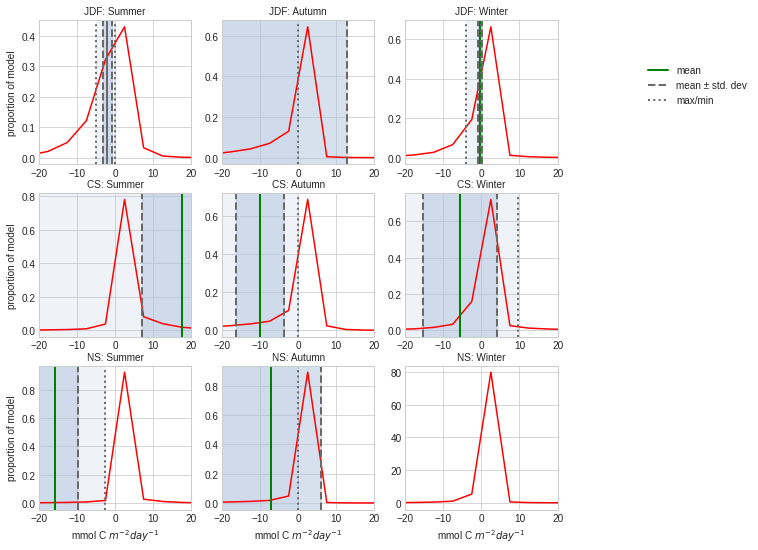

In [370]:



#convert mmol/m2/s to mmol/m2/day

#1 is jdf, 4 is haro, 2 is n.strait 3 is s. strait

fact = 0.6
tms = 20
tmew = 4
tsz = 10
trot = 0
xmi = -20
xma = 20
tcol = 'dimgrey'
tcol1 = 'g'
tcol2 = 'lightsteelblue'
fig = plt.figure(figsize=(15.5*fact,15*fact))

ax1 = fig.add_subplot(3,3,1)

#plt.legend(bbox_to_anchor=(1.04,0.7), loc="upper left", fontsize = tsz)
ax1.tick_params(labelsize=tsz)
#ax1.set_xlabel('mmol C $m^{-2}day^{-1}$',fontsize =tsz)
ax1.set_title('JDF: Summer', fontsize = tsz)

ax1.plot(bin_cent_wh,BR_JH_S/np.nansum(BR_JH_S), color = 'red')
ax1.set_xlim([xmi,xma])

#lines
ax1.axvline(JDF_S_mean, color = tcol, linestyle = '-' , lw = 2)
ax1.axvline(JDF_S_mean-JDF_S_std, color = tcol, linestyle = '--' , lw = 2)
ax1.axvline(JDF_S_mean+JDF_S_std, color = tcol, linestyle = '--' , lw = 2)
ax1.axvspan(JDF_S_mean-JDF_S_std, JDF_S_mean+JDF_S_std, alpha=0.5, color=tcol2)
ax1.axvline(JDF_S_max, color = tcol, linestyle = ':' , lw = 2)
ax1.axvline(JDF_S_min, color = tcol, linestyle = ':' , lw = 2)
ax1.axvspan(JDF_S_min, JDF_S_max, alpha=0.2, color=tcol2)
ax1.set_ylabel('proportion of model')
plt.xticks(rotation=trot)

ax1 = fig.add_subplot(3,3,2)

#plt.legend(bbox_to_anchor=(1.04,0.7), loc="upper left", fontsize = tsz)
ax1.tick_params(labelsize=tsz)
#ax1.set_xlabel('mmol C $m^{-2}day^{-1}$',fontsize =tsz)
ax1.set_title('JDF: Autumn', fontsize = tsz)
ax1.plot(bin_cent_wh,BR_JH_A/np.nansum(BR_JH_A), color = 'red')
ax1.set_xlim([xmi,xma])

#lines
ax1.axvline(JDF_A_mean, color = tcol1, linestyle = '-' , lw = 2)
ax1.axvline(JDF_A_mean-JDF_A_std, color = tcol, linestyle = '--' , lw = 2)
ax1.axvline(JDF_A_mean+JDF_A_std, color = tcol, linestyle = '--' , lw = 2)
ax1.axvspan(JDF_A_mean-JDF_A_std, JDF_A_mean+JDF_A_std, alpha=0.5, color=tcol2)
ax1.axvline(JDF_A_max, color = tcol, linestyle = ':' , lw = 2)
ax1.axvline(JDF_A_min, color = tcol, linestyle = ':' , lw = 2)
ax1.axvspan(JDF_A_min, JDF_A_max, alpha=0.2, color=tcol2)
plt.xticks(rotation=trot)

ax1 = fig.add_subplot(3,3,3)

#plt.legend(bbox_to_anchor=(1.04,0.7), loc="upper left", fontsize = tsz)
ax1.tick_params(labelsize=tsz)
#ax1.set_xlabel('mmol C $m^{-2}day^{-1}$',fontsize =tsz)
ax1.set_title('JDF: Winter', fontsize = tsz)
ax1.plot(bin_cent_wh,BR_JH_W/np.nansum(BR_JH_W), color = 'red')
ax1.set_xlim([xmi,xma])

#lines
ax1.axvline(JDF_W_mean, color = tcol1, linestyle = '-' , lw = 2)
ax1.axvline(JDF_W_mean-JDF_W_std, color = tcol, linestyle = '--' , lw = 2)
ax1.axvline(JDF_W_mean+JDF_W_std, color = tcol, linestyle = '--' , lw = 2)
ax1.axvspan(JDF_W_mean-JDF_W_std, JDF_W_mean+JDF_W_std, alpha=0.5, color=tcol2)
ax1.axvline(JDF_W_max, color = tcol, linestyle = ':' , lw = 2)
ax1.axvline(JDF_W_min, color = tcol, linestyle = ':' , lw = 2)
ax1.axvspan(JDF_W_min, JDF_W_max, alpha=0.2, color=tcol2)
plt.xticks(rotation=trot)

ax1 = fig.add_subplot(3,3,4)

#plt.legend(bbox_to_anchor=(1.04,0.7), loc="upper left", fontsize = tsz)
ax1.tick_params(labelsize=tsz)
#ax1.set_xlabel('mmol C $m^{-2}day^{-1}$',fontsize =tsz)
ax1.set_title('CS: Summer', fontsize = tsz)
ax1.plot(bin_cent_wh,BR_CS_S/np.nansum(BR_CS_S), color = 'red')
ax1.set_xlim([xmi,xma])

#lines
ax1.axvline(CS_S_mean, color = tcol1, linestyle = '-' , lw = 2)
ax1.axvline(CS_S_mean-CS_S_std, color = tcol, linestyle = '--' , lw = 2)
ax1.axvline(CS_S_mean+CS_S_std, color = tcol, linestyle = '--' , lw = 2)
ax1.axvspan(CS_S_mean-CS_S_std, CS_S_mean+CS_S_std, alpha=0.5, color=tcol2)
ax1.axvline(CS_S_max, color = tcol, linestyle = ':' , lw = 2)
ax1.axvline(CS_S_min, color = tcol, linestyle = ':' , lw = 2)
ax1.axvspan(CS_S_min, CS_S_max, alpha=0.2, color=tcol2)
plt.xticks(rotation=trot)
ax1.set_ylabel('proportion of model')

ax1 = fig.add_subplot(3,3,5)

#plt.legend(bbox_to_anchor=(1.04,0.7), loc="upper left", fontsize = tsz)
ax1.tick_params(labelsize=tsz)
#ax1.set_xlabel('mmol C $m^{-2}day^{-1}$',fontsize =tsz)
ax1.set_title('CS: Autumn', fontsize = tsz)
ax1.plot(bin_cent_wh,BR_CS_A/np.nansum(BR_CS_A), color = 'red')
ax1.set_xlim([xmi,xma])
#lines
ax1.axvline(CS_A_mean, color = tcol1, linestyle = '-' , lw = 2)
ax1.axvline(CS_A_mean-CS_A_std, color = tcol, linestyle = '--' , lw = 2)
ax1.axvline(CS_A_mean+CS_A_std, color = tcol, linestyle = '--' , lw = 2)
ax1.axvspan(CS_A_mean-CS_A_std, CS_A_mean+CS_A_std, alpha=0.5, color=tcol2)
ax1.axvline(CS_A_max, color = tcol, linestyle = ':' , lw = 2)
ax1.axvline(CS_A_min, color = tcol, linestyle = ':' , lw = 2)
ax1.axvspan(CS_A_min, CS_A_max, alpha=0.2, color=tcol2)
#ax1.set_ylabel('proportion of model')

plt.xticks(rotation=trot)

ax1 = fig.add_subplot(3,3,6)


#plt.legend(bbox_to_anchor=(1.04,0.7), loc="upper left", fontsize = tsz)
ax1.tick_params(labelsize=tsz)
#ax1.set_xlabel('mmol C $m^{-2}day^{-1}$',fontsize =tsz)
ax1.set_title('CS: Winter', fontsize = tsz)
ax1.plot(bin_cent_wh,BR_CS_W/np.nansum(BR_CS_W), color = 'red')
ax1.set_xlim([xmi,xma])
#lines
ax1.axvline(CS_W_mean, color = tcol1, linestyle = '-' , lw = 2)
ax1.axvline(CS_W_mean-CS_W_std, color = tcol, linestyle = '--' , lw = 2)
ax1.axvline(CS_W_mean+CS_W_std, color = tcol, linestyle = '--' , lw = 2)
ax1.axvspan(CS_W_mean-CS_W_std, CS_W_mean+CS_W_std, alpha=0.5, color=tcol2)
ax1.axvline(CS_W_max, color = tcol, linestyle = ':' , lw = 2)
ax1.axvline(CS_W_min, color = tcol, linestyle = ':' , lw = 2)
ax1.axvspan(CS_W_min, CS_W_max, alpha=0.2, color=tcol2)
#ax1.set_ylabel('proportion of model')
plt.xticks(rotation=trot)

###CS
ax1 = fig.add_subplot(3,3,7)
ax1.set_ylabel('proportion of model')
#plt.legend(bbox_to_anchor=(1.04,0.7), loc="upper left", fontsize = tsz)
ax1.tick_params(labelsize=tsz)
ax1.set_xlabel('mmol C $m^{-2}day^{-1}$',fontsize =tsz)
ax1.set_title('NS: Summer', fontsize = tsz)
ax1.plot(bin_cent_wh,BR_NS_S/np.nansum(BR_NS_S), color = 'red')
ax1.set_xlim([xmi,xma])
#lines
ax1.axvline(NS_S_mean, color = tcol1, linestyle = '-' , lw = 2)
ax1.axvline(NS_S_mean-NS_S_std, color = tcol, linestyle = '--' , lw = 2)
ax1.axvline(NS_S_mean+NS_S_std, color = tcol, linestyle = '--' , lw = 2)
ax1.axvspan(NS_S_mean-NS_S_std, NS_S_mean+NS_S_std, alpha=0.5, color=tcol2)
ax1.axvline(NS_S_max, color = tcol, linestyle = ':' , lw = 2)
ax1.axvline(NS_S_min, color = tcol, linestyle = ':' , lw = 2)
ax1.axvspan(NS_S_min, NS_S_max, alpha=0.2, color=tcol2)
plt.xticks(rotation=trot)

ax1 = fig.add_subplot(3,3,8)

#plt.legend(bbox_to_anchor=(1.04,0.7), loc="upper left", fontsize = tsz)
ax1.tick_params(labelsize=tsz)
ax1.set_xlabel('mmol C $m^{-2}day^{-1}$',fontsize =tsz)
ax1.set_title('NS: Autumn', fontsize = tsz)
ax1.plot(bin_cent_wh,BR_NS_A/np.nansum(BR_NS_A), color = 'red')
ax1.set_xlim([xmi,xma])
#lines
ax1.axvline(NS_A_mean, color = tcol1, linestyle = '-' , lw = 2, label = 'mean')
ax1.axvline(NS_A_mean-NS_A_std, color = tcol, linestyle = '--' , lw = 2, label = 'mean ± std. dev')
ax1.axvline(NS_A_mean+NS_A_std, color = tcol, linestyle = '--' , lw = 2)
ax1.axvspan(NS_A_mean-NS_A_std, NS_A_mean+NS_A_std, alpha=0.5, color=tcol2)
ax1.axvline(NS_A_max, color = tcol, linestyle = ':', label = 'max/min', lw = 2)
ax1.axvline(NS_A_min, color = tcol, linestyle = ':' , lw = 2)
ax1.axvspan(NS_A_min, NS_A_max, alpha=0.2, color=tcol2)
plt.legend(bbox_to_anchor=[3.5,3.15])
plt.xticks(rotation=trot)

ax1 = fig.add_subplot(3,3,9)

#plt.legend(bbox_to_anchor=(1.04,0.7), loc="upper left", fontsize = tsz)
ax1.tick_params(labelsize=tsz)
ax1.set_xlabel('mmol C $m^{-2}day^{-1}$',fontsize =tsz)
ax1.set_title('NS: Winter', fontsize = tsz)
ax1.plot(bin_cent_wh,BR_NS_W/np.nansum(csize), color = 'red')
ax1.set_xlim([xmi,xma])



fig.tight_layout()
#lines
#no lines (no data)


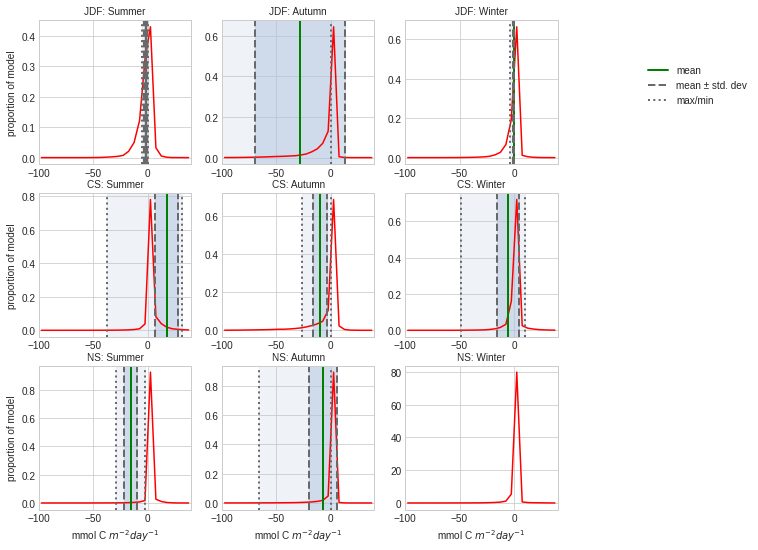

In [384]:



#convert mmol/m2/s to mmol/m2/day

#1 is jdf, 4 is haro, 2 is n.strait 3 is s. strait

fact = 0.6
tms = 20
tmew = 4
tsz = 10
trot = 0
xmi = -100
xma = 40
tcol = 'dimgrey'
tcol1 = 'g'
tcol2 = 'lightsteelblue'
fig = plt.figure(figsize=(15.5*fact,15*fact))

ax1 = fig.add_subplot(3,3,1)

#plt.legend(bbox_to_anchor=(1.04,0.7), loc="upper left", fontsize = tsz)
ax1.tick_params(labelsize=tsz)
#ax1.set_xlabel('mmol C $m^{-2}day^{-1}$',fontsize =tsz)
ax1.set_title('JDF: Summer', fontsize = tsz)

ax1.plot(bin_cent_wh,BR_JH_S/np.nansum(BR_JH_S), color = 'red')
ax1.set_xlim([xmi,xma])

#lines
ax1.axvline(JDF_S_mean, color = tcol, linestyle = '-' , lw = 2)
ax1.axvline(JDF_S_mean-JDF_S_std, color = tcol, linestyle = '--' , lw = 2)
ax1.axvline(JDF_S_mean+JDF_S_std, color = tcol, linestyle = '--' , lw = 2)
ax1.axvspan(JDF_S_mean-JDF_S_std, JDF_S_mean+JDF_S_std, alpha=0.5, color=tcol2)
ax1.axvline(JDF_S_max, color = tcol, linestyle = ':' , lw = 2)
ax1.axvline(JDF_S_min, color = tcol, linestyle = ':' , lw = 2)
ax1.axvspan(JDF_S_min, JDF_S_max, alpha=0.2, color=tcol2)
ax1.set_ylabel('proportion of model')
plt.xticks(rotation=trot)

ax1 = fig.add_subplot(3,3,2)

#plt.legend(bbox_to_anchor=(1.04,0.7), loc="upper left", fontsize = tsz)
ax1.tick_params(labelsize=tsz)
#ax1.set_xlabel('mmol C $m^{-2}day^{-1}$',fontsize =tsz)
ax1.set_title('JDF: Autumn', fontsize = tsz)
ax1.plot(bin_cent_wh,BR_JH_A/np.nansum(BR_JH_A), color = 'red')
ax1.set_xlim([xmi,xma])

#lines
ax1.axvline(JDF_A_mean, color = tcol1, linestyle = '-' , lw = 2)
ax1.axvline(JDF_A_mean-JDF_A_std, color = tcol, linestyle = '--' , lw = 2)
ax1.axvline(JDF_A_mean+JDF_A_std, color = tcol, linestyle = '--' , lw = 2)
ax1.axvspan(JDF_A_mean-JDF_A_std, JDF_A_mean+JDF_A_std, alpha=0.5, color=tcol2)
ax1.axvline(JDF_A_max, color = tcol, linestyle = ':' , lw = 2)
ax1.axvline(JDF_A_min, color = tcol, linestyle = ':' , lw = 2)
ax1.axvspan(JDF_A_min, JDF_A_max, alpha=0.2, color=tcol2)
plt.xticks(rotation=trot)

ax1 = fig.add_subplot(3,3,3)

#plt.legend(bbox_to_anchor=(1.04,0.7), loc="upper left", fontsize = tsz)
ax1.tick_params(labelsize=tsz)
#ax1.set_xlabel('mmol C $m^{-2}day^{-1}$',fontsize =tsz)
ax1.set_title('JDF: Winter', fontsize = tsz)
ax1.plot(bin_cent_wh,BR_JH_W/np.nansum(BR_JH_W), color = 'red')
ax1.set_xlim([xmi,xma])

#lines
ax1.axvline(JDF_W_mean, color = tcol1, linestyle = '-' , lw = 2)
ax1.axvline(JDF_W_mean-JDF_W_std, color = tcol, linestyle = '--' , lw = 2)
ax1.axvline(JDF_W_mean+JDF_W_std, color = tcol, linestyle = '--' , lw = 2)
ax1.axvspan(JDF_W_mean-JDF_W_std, JDF_W_mean+JDF_W_std, alpha=0.5, color=tcol2)
ax1.axvline(JDF_W_max, color = tcol, linestyle = ':' , lw = 2)
ax1.axvline(JDF_W_min, color = tcol, linestyle = ':' , lw = 2)
ax1.axvspan(JDF_W_min, JDF_W_max, alpha=0.2, color=tcol2)
plt.xticks(rotation=trot)

ax1 = fig.add_subplot(3,3,4)

#plt.legend(bbox_to_anchor=(1.04,0.7), loc="upper left", fontsize = tsz)
ax1.tick_params(labelsize=tsz)
#ax1.set_xlabel('mmol C $m^{-2}day^{-1}$',fontsize =tsz)
ax1.set_title('CS: Summer', fontsize = tsz)
ax1.plot(bin_cent_wh,BR_CS_S/np.nansum(BR_CS_S), color = 'red')
ax1.set_xlim([xmi,xma])

#lines
ax1.axvline(CS_S_mean, color = tcol1, linestyle = '-' , lw = 2)
ax1.axvline(CS_S_mean-CS_S_std, color = tcol, linestyle = '--' , lw = 2)
ax1.axvline(CS_S_mean+CS_S_std, color = tcol, linestyle = '--' , lw = 2)
ax1.axvspan(CS_S_mean-CS_S_std, CS_S_mean+CS_S_std, alpha=0.5, color=tcol2)
ax1.axvline(CS_S_max, color = tcol, linestyle = ':' , lw = 2)
ax1.axvline(CS_S_min, color = tcol, linestyle = ':' , lw = 2)
ax1.axvspan(CS_S_min, CS_S_max, alpha=0.2, color=tcol2)
plt.xticks(rotation=trot)
ax1.set_ylabel('proportion of model')

ax1 = fig.add_subplot(3,3,5)

#plt.legend(bbox_to_anchor=(1.04,0.7), loc="upper left", fontsize = tsz)
ax1.tick_params(labelsize=tsz)
#ax1.set_xlabel('mmol C $m^{-2}day^{-1}$',fontsize =tsz)
ax1.set_title('CS: Autumn', fontsize = tsz)
ax1.plot(bin_cent_wh,BR_CS_A/np.nansum(BR_CS_A), color = 'red')
ax1.set_xlim([xmi,xma])
#lines
ax1.axvline(CS_A_mean, color = tcol1, linestyle = '-' , lw = 2)
ax1.axvline(CS_A_mean-CS_A_std, color = tcol, linestyle = '--' , lw = 2)
ax1.axvline(CS_A_mean+CS_A_std, color = tcol, linestyle = '--' , lw = 2)
ax1.axvspan(CS_A_mean-CS_A_std, CS_A_mean+CS_A_std, alpha=0.5, color=tcol2)
ax1.axvline(CS_A_max, color = tcol, linestyle = ':' , lw = 2)
ax1.axvline(CS_A_min, color = tcol, linestyle = ':' , lw = 2)
ax1.axvspan(CS_A_min, CS_A_max, alpha=0.2, color=tcol2)
#ax1.set_ylabel('proportion of model')

plt.xticks(rotation=trot)

ax1 = fig.add_subplot(3,3,6)


#plt.legend(bbox_to_anchor=(1.04,0.7), loc="upper left", fontsize = tsz)
ax1.tick_params(labelsize=tsz)
#ax1.set_xlabel('mmol C $m^{-2}day^{-1}$',fontsize =tsz)
ax1.set_title('CS: Winter', fontsize = tsz)
ax1.plot(bin_cent_wh,BR_CS_W/np.nansum(BR_CS_W), color = 'red')
ax1.set_xlim([xmi,xma])
#lines
ax1.axvline(CS_W_mean, color = tcol1, linestyle = '-' , lw = 2)
ax1.axvline(CS_W_mean-CS_W_std, color = tcol, linestyle = '--' , lw = 2)
ax1.axvline(CS_W_mean+CS_W_std, color = tcol, linestyle = '--' , lw = 2)
ax1.axvspan(CS_W_mean-CS_W_std, CS_W_mean+CS_W_std, alpha=0.5, color=tcol2)
ax1.axvline(CS_W_max, color = tcol, linestyle = ':' , lw = 2)
ax1.axvline(CS_W_min, color = tcol, linestyle = ':' , lw = 2)
ax1.axvspan(CS_W_min, CS_W_max, alpha=0.2, color=tcol2)
#ax1.set_ylabel('proportion of model')
plt.xticks(rotation=trot)

###CS
ax1 = fig.add_subplot(3,3,7)
ax1.set_ylabel('proportion of model')
#plt.legend(bbox_to_anchor=(1.04,0.7), loc="upper left", fontsize = tsz)
ax1.tick_params(labelsize=tsz)
ax1.set_xlabel('mmol C $m^{-2}day^{-1}$',fontsize =tsz)
ax1.set_title('NS: Summer', fontsize = tsz)
ax1.plot(bin_cent_wh,BR_NS_S/np.nansum(BR_NS_S), color = 'red')
ax1.set_xlim([xmi,xma])
#lines
ax1.axvline(NS_S_mean, color = tcol1, linestyle = '-' , lw = 2)
ax1.axvline(NS_S_mean-NS_S_std, color = tcol, linestyle = '--' , lw = 2)
ax1.axvline(NS_S_mean+NS_S_std, color = tcol, linestyle = '--' , lw = 2)
ax1.axvspan(NS_S_mean-NS_S_std, NS_S_mean+NS_S_std, alpha=0.5, color=tcol2)
ax1.axvline(NS_S_max, color = tcol, linestyle = ':' , lw = 2)
ax1.axvline(NS_S_min, color = tcol, linestyle = ':' , lw = 2)
ax1.axvspan(NS_S_min, NS_S_max, alpha=0.2, color=tcol2)
plt.xticks(rotation=trot)

ax1 = fig.add_subplot(3,3,8)

#plt.legend(bbox_to_anchor=(1.04,0.7), loc="upper left", fontsize = tsz)
ax1.tick_params(labelsize=tsz)
ax1.set_xlabel('mmol C $m^{-2}day^{-1}$',fontsize =tsz)
ax1.set_title('NS: Autumn', fontsize = tsz)
ax1.plot(bin_cent_wh,BR_NS_A/np.nansum(BR_NS_A), color = 'red')
ax1.set_xlim([xmi,xma])
#lines
ax1.axvline(NS_A_mean, color = tcol1, linestyle = '-' , lw = 2, label = 'mean')
ax1.axvline(NS_A_mean-NS_A_std, color = tcol, linestyle = '--' , lw = 2, label = 'mean ± std. dev')
ax1.axvline(NS_A_mean+NS_A_std, color = tcol, linestyle = '--' , lw = 2)
ax1.axvspan(NS_A_mean-NS_A_std, NS_A_mean+NS_A_std, alpha=0.5, color=tcol2)
ax1.axvline(NS_A_max, color = tcol, linestyle = ':', label = 'max/min', lw = 2)
ax1.axvline(NS_A_min, color = tcol, linestyle = ':' , lw = 2)
ax1.axvspan(NS_A_min, NS_A_max, alpha=0.2, color=tcol2)
plt.legend(bbox_to_anchor=[3.5,3.15])
plt.xticks(rotation=trot)

ax1 = fig.add_subplot(3,3,9)

#plt.legend(bbox_to_anchor=(1.04,0.7), loc="upper left", fontsize = tsz)
ax1.tick_params(labelsize=tsz)
ax1.set_xlabel('mmol C $m^{-2}day^{-1}$',fontsize =tsz)
ax1.set_title('NS: Winter', fontsize = tsz)
ax1.plot(bin_cent_wh,BR_NS_W/np.nansum(csize), color = 'red')
ax1.set_xlim([xmi,xma])



fig.tight_layout()
#lines
#no lines (no data)


In [369]:
print(np.sum(BR_JH_S))

682370500962.9802


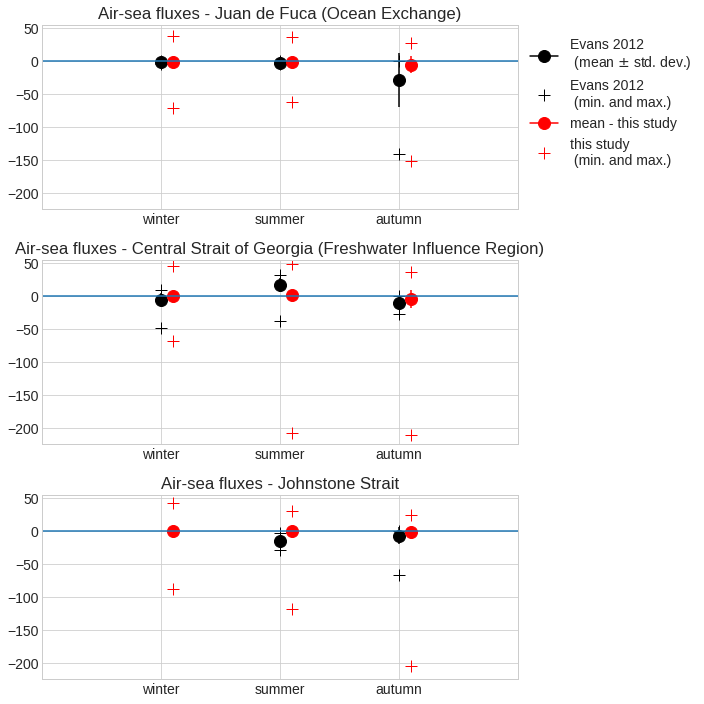

In [272]:
plt.rcParams.update({'font.size': 14})
font = {'family' : 'normal',
'weight' : 'bold',
'size'   : 14}
plt.rcParams['lines.markersize'] = 12

fact = 0.5
fig, axs = plt.subplots(3,1, figsize=(20*fact, 20*fact), facecolor='w', edgecolor='k')\

# BR_NS_S_nn

#winter summer autumn
axs = axs.ravel()
axs[0].plot(1,JDF_W_mean,marker = 'o', color = 'k',label = 'Evans 2012 \n (mean $\pm$ std. dev.)' )
axs[0].errorbar(1,JDF_W_mean,yerr = JDF_W_std, color = 'k',ecolor ='k' )
axs[0].plot(1,JDF_W_min,marker = '+', color = 'k', linestyle = 'none', label = 'Evans 2012 \n (min. and max.)')
axs[0].plot(1,JDF_W_max,marker = '+', color = 'k')

axs[0].plot(1.1,BR_JH_W_avg,marker = 'o', color = 'r',label = 'mean - this study' )
axs[0].errorbar(1.1,BR_JH_W_avg,yerr = BR_JH_W_std, color = 'r',ecolor ='r')
axs[0].plot(1.1,BR_JH_W_min,marker = '+', color = 'r', linestyle = 'none', label = 'this study \n (min. and max.)')
axs[0].plot(1.1,BR_JH_W_max,marker = '+', color = 'r')


axs[0].plot(2,JDF_S_mean,marker = 'o', color = 'k')
axs[0].errorbar(2,JDF_S_mean,yerr = JDF_S_std, color = 'k', ecolor = 'k')
axs[0].plot(2,JDF_S_min,marker = '+', color = 'k')
axs[0].plot(2,JDF_S_max,marker = '+', color = 'k')

axs[0].plot(2.1,BR_JH_S_avg,marker = 'o', color = 'r')
axs[0].errorbar(2.1,BR_JH_S_avg,yerr = BR_JH_S_std, color = 'r',ecolor ='r')
axs[0].plot(2.1,BR_JH_S_min,marker = '+', color = 'r', linestyle = 'none')
axs[0].plot(2.1,BR_JH_S_max,marker = '+', color = 'r')

axs[0].plot(3,JDF_A_mean,marker = 'o', color = 'k')
axs[0].errorbar(3,JDF_A_mean,yerr = JDF_A_std, color = 'k', ecolor = 'k')
axs[0].plot(3,JDF_A_min,marker = '+', color = 'k')
axs[0].plot(3,JDF_A_max,marker = '+', color = 'k')

axs[0].plot(3.1,BR_JH_A_avg,marker = 'o', color = 'r')
axs[0].errorbar(3.1,BR_JH_A_avg,yerr = BR_JH_A_std, color = 'r',ecolor ='r')
axs[0].plot(3.1,BR_JH_A_min,marker = '+', color = 'r', linestyle = 'none')
axs[0].plot(3.1,BR_JH_A_max,marker = '+', color = 'r')

axs[0].set_title('Air-sea fluxes - Juan de Fuca (Ocean Exchange)')
axs[0].legend(bbox_to_anchor = [1, 1])
######
axs[1].plot(1,CS_W_mean,marker = 'o', color = 'k',label = 'Evans 2012 (mean $\pm$ std. dev.)' )
axs[1].errorbar(1,CS_W_mean,yerr = CS_W_std, color = 'k',ecolor ='k' )
axs[1].plot(1,CS_W_min,marker = '+', color = 'k', linestyle = 'none', label = 'Evans 2012 (min. and max.)')
axs[1].plot(1,CS_W_max,marker = '+', color = 'k')

axs[1].plot(1.1,BR_CS_W_avg,marker = 'o', color = 'r',label = 'mean - this study' )
axs[1].errorbar(1.1,BR_CS_W_avg,yerr = BR_CS_W_std, color = 'r',ecolor ='r')
axs[1].plot(1.1,BR_CS_W_min,marker = '+', color = 'r', linestyle = 'none', label = 'this study (min. and max.)')
axs[1].plot(1.1,BR_CS_W_max,marker = '+', color = 'r')


axs[1].plot(2,CS_S_mean,marker = 'o', color = 'k')
axs[1].errorbar(2,CS_S_mean,yerr = CS_S_std, color = 'k', ecolor = 'k')
axs[1].plot(2,CS_S_min,marker = '+', color = 'k')
axs[1].plot(2,CS_S_max,marker = '+', color = 'k')

axs[1].plot(2.1,BR_CS_S_avg,marker = 'o', color = 'r')
axs[1].errorbar(2.1,BR_CS_S_avg,yerr = BR_CS_S_std, color = 'r',ecolor ='r')
axs[1].plot(2.1,BR_CS_S_min,marker = '+', color = 'r', linestyle = 'none')
axs[1].plot(2.1,BR_CS_S_max,marker = '+', color = 'r')

axs[1].plot(3,CS_A_mean,marker = 'o', color = 'k')
axs[1].errorbar(3,CS_A_mean,yerr = CS_A_std, color = 'k', ecolor = 'k')
axs[1].plot(3,CS_A_min,marker = '+', color = 'k')
axs[1].plot(3,CS_A_max,marker = '+', color = 'k')

axs[1].plot(3.1,BR_CS_A_avg,marker = 'o', color = 'r')
axs[1].errorbar(3.1,BR_CS_A_avg,yerr = BR_CS_A_std, color = 'r',ecolor ='r')
axs[1].plot(3.1,BR_CS_A_min,marker = '+', color = 'r', linestyle = 'none')
axs[1].plot(3.1,BR_CS_A_max,marker = '+', color = 'r')
axs[1].set_title('Air-sea fluxes - Central Strait of Georgia (Freshwater Influence Region)')
#####
axs[2].plot(1,NS_W_mean,marker = 'o', color = 'k',label = 'Evans 2012 (mean $\pm$ std. dev.)' )
axs[2].errorbar(1,NS_W_mean,yerr = NS_W_std, color = 'k',ecolor ='k' )
axs[2].plot(1,NS_W_min,marker = '+', color = 'k', linestyle = 'none', label = 'Evans 2012 (min. and max.)')
axs[2].plot(1,NS_W_max,marker = '+', color = 'k')

axs[2].plot(1.1,BR_NS_W_avg,marker = 'o', color = 'r',label = 'mean - this study' )
axs[2].errorbar(1.1,BR_NS_W_avg,yerr = BR_NS_W_std, color = 'r',ecolor ='r')
axs[2].plot(1.1,BR_NS_W_min,marker = '+', color = 'r', linestyle = 'none', label = 'this study (min. and max.)')
axs[2].plot(1.1,BR_NS_W_max,marker = '+', color = 'r')


axs[2].plot(2,NS_S_mean,marker = 'o', color = 'k')
axs[2].errorbar(2,NS_S_mean,yerr = NS_S_std, color = 'k', ecolor = 'k')
axs[2].plot(2,NS_S_min,marker = '+', color = 'k')
axs[2].plot(2,NS_S_max,marker = '+', color = 'k')

axs[2].plot(2.1,BR_NS_S_avg,marker = 'o', color = 'r')
axs[2].errorbar(2.1,BR_NS_S_avg,yerr = BR_NS_S_std, color = 'r',ecolor ='r')
axs[2].plot(2.1,BR_NS_S_min,marker = '+', color = 'r', linestyle = 'none')
axs[2].plot(2.1,BR_NS_S_max,marker = '+', color = 'r')

axs[2].plot(3,NS_A_mean,marker = 'o', color = 'k')
axs[2].errorbar(3,NS_A_mean,yerr = NS_A_std, color = 'k', ecolor = 'k')
axs[2].plot(3,NS_A_min,marker = '+', color = 'k')
axs[2].plot(3,NS_A_max,marker = '+', color = 'k')

axs[2].plot(3.1,BR_NS_A_avg,marker = 'o', color = 'r')
axs[2].errorbar(3.1,BR_NS_A_avg,yerr = BR_NS_A_std, color = 'r',ecolor ='r')
axs[2].plot(3.1,BR_NS_A_min,marker = '+', color = 'r', linestyle = 'none')
axs[2].plot(3.1,BR_NS_A_max,marker = '+', color = 'r')
axs[2].set_title('Air-sea fluxes - Johnstone Strait')

# axs[2].plot(2.1,np.mean(BR_NS_S_nn),marker = 'o', color = 'k')

for i in range(0,3):
    axs[i].set_xlim([0,4])
    axs[i].set_ylim([-225,55])
    axs[i].set_xticks([1,2,3])
    axs[i].set_xticklabels(['winter','summer','autumn'])
    axs[i].axhline(y=0)
    #plt.errorbar(n, y, yerr = yerror, ecolor = 'k', capsize = 5)
    
plt.tight_layout()

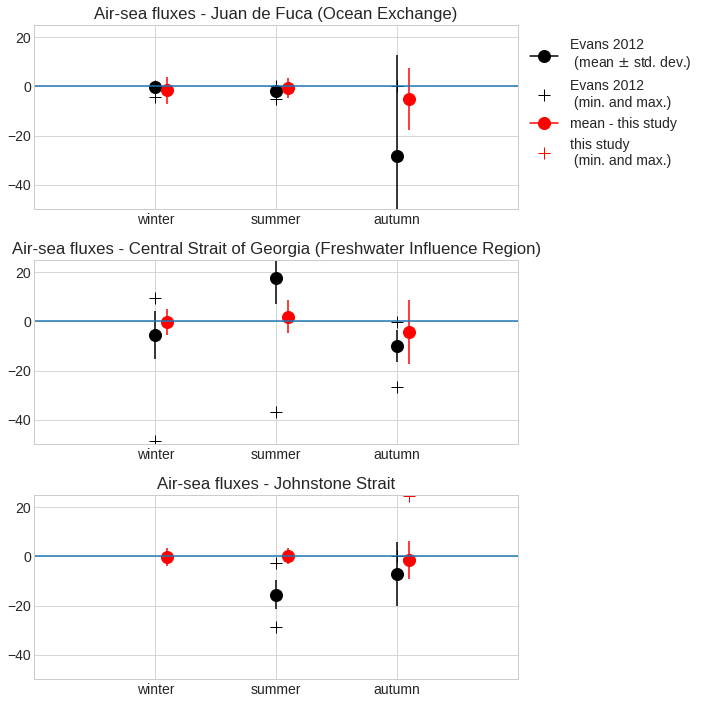

In [274]:
plt.rcParams.update({'font.size': 14})
font = {'family' : 'normal',
'weight' : 'bold',
'size'   : 14}
plt.rcParams['lines.markersize'] = 12

fact = 0.5
fig, axs = plt.subplots(3,1, figsize=(20*fact, 20*fact), facecolor='w', edgecolor='k')\

# BR_NS_S_nn

#winter summer autumn
axs = axs.ravel()
axs[0].plot(1,JDF_W_mean,marker = 'o', color = 'k',label = 'Evans 2012 \n (mean $\pm$ std. dev.)' )
axs[0].errorbar(1,JDF_W_mean,yerr = JDF_W_std, color = 'k',ecolor ='k' )
axs[0].plot(1,JDF_W_min,marker = '+', color = 'k', linestyle = 'none', label = 'Evans 2012 \n (min. and max.)')
axs[0].plot(1,JDF_W_max,marker = '+', color = 'k')

axs[0].plot(1.1,BR_JH_W_avg,marker = 'o', color = 'r',label = 'mean - this study' )
axs[0].errorbar(1.1,BR_JH_W_avg,yerr = BR_JH_W_std, color = 'r',ecolor ='r')
axs[0].plot(1.1,BR_JH_W_min,marker = '+', color = 'r', linestyle = 'none', label = 'this study \n (min. and max.)')
axs[0].plot(1.1,BR_JH_W_max,marker = '+', color = 'r')


axs[0].plot(2,JDF_S_mean,marker = 'o', color = 'k')
axs[0].errorbar(2,JDF_S_mean,yerr = JDF_S_std, color = 'k', ecolor = 'k')
axs[0].plot(2,JDF_S_min,marker = '+', color = 'k')
axs[0].plot(2,JDF_S_max,marker = '+', color = 'k')

axs[0].plot(2.1,BR_JH_S_avg,marker = 'o', color = 'r')
axs[0].errorbar(2.1,BR_JH_S_avg,yerr = BR_JH_S_std, color = 'r',ecolor ='r')
axs[0].plot(2.1,BR_JH_S_min,marker = '+', color = 'r', linestyle = 'none')
axs[0].plot(2.1,BR_JH_S_max,marker = '+', color = 'r')

axs[0].plot(3,JDF_A_mean,marker = 'o', color = 'k')
axs[0].errorbar(3,JDF_A_mean,yerr = JDF_A_std, color = 'k', ecolor = 'k')
axs[0].plot(3,JDF_A_min,marker = '+', color = 'k')
axs[0].plot(3,JDF_A_max,marker = '+', color = 'k')

axs[0].plot(3.1,BR_JH_A_avg,marker = 'o', color = 'r')
axs[0].errorbar(3.1,BR_JH_A_avg,yerr = BR_JH_A_std, color = 'r',ecolor ='r')
axs[0].plot(3.1,BR_JH_A_min,marker = '+', color = 'r', linestyle = 'none')
axs[0].plot(3.1,BR_JH_A_max,marker = '+', color = 'r')

axs[0].set_title('Air-sea fluxes - Juan de Fuca (Ocean Exchange)')
axs[0].legend(bbox_to_anchor = [1, 1])
######
axs[1].plot(1,CS_W_mean,marker = 'o', color = 'k',label = 'Evans 2012 (mean $\pm$ std. dev.)' )
axs[1].errorbar(1,CS_W_mean,yerr = CS_W_std, color = 'k',ecolor ='k' )
axs[1].plot(1,CS_W_min,marker = '+', color = 'k', linestyle = 'none', label = 'Evans 2012 (min. and max.)')
axs[1].plot(1,CS_W_max,marker = '+', color = 'k')

axs[1].plot(1.1,BR_CS_W_avg,marker = 'o', color = 'r',label = 'mean - this study' )
axs[1].errorbar(1.1,BR_CS_W_avg,yerr = BR_CS_W_std, color = 'r',ecolor ='r')
axs[1].plot(1.1,BR_CS_W_min,marker = '+', color = 'r', linestyle = 'none', label = 'this study (min. and max.)')
axs[1].plot(1.1,BR_CS_W_max,marker = '+', color = 'r')


axs[1].plot(2,CS_S_mean,marker = 'o', color = 'k')
axs[1].errorbar(2,CS_S_mean,yerr = CS_S_std, color = 'k', ecolor = 'k')
axs[1].plot(2,CS_S_min,marker = '+', color = 'k')
axs[1].plot(2,CS_S_max,marker = '+', color = 'k')

axs[1].plot(2.1,BR_CS_S_avg,marker = 'o', color = 'r')
axs[1].errorbar(2.1,BR_CS_S_avg,yerr = BR_CS_S_std, color = 'r',ecolor ='r')
axs[1].plot(2.1,BR_CS_S_min,marker = '+', color = 'r', linestyle = 'none')
axs[1].plot(2.1,BR_CS_S_max,marker = '+', color = 'r')

axs[1].plot(3,CS_A_mean,marker = 'o', color = 'k')
axs[1].errorbar(3,CS_A_mean,yerr = CS_A_std, color = 'k', ecolor = 'k')
axs[1].plot(3,CS_A_min,marker = '+', color = 'k')
axs[1].plot(3,CS_A_max,marker = '+', color = 'k')

axs[1].plot(3.1,BR_CS_A_avg,marker = 'o', color = 'r')
axs[1].errorbar(3.1,BR_CS_A_avg,yerr = BR_CS_A_std, color = 'r',ecolor ='r')
axs[1].plot(3.1,BR_CS_A_min,marker = '+', color = 'r', linestyle = 'none')
axs[1].plot(3.1,BR_CS_A_max,marker = '+', color = 'r')
axs[1].set_title('Air-sea fluxes - Central Strait of Georgia (Freshwater Influence Region)')
#####
axs[2].plot(1,NS_W_mean,marker = 'o', color = 'k',label = 'Evans 2012 (mean $\pm$ std. dev.)' )
axs[2].errorbar(1,NS_W_mean,yerr = NS_W_std, color = 'k',ecolor ='k' )
axs[2].plot(1,NS_W_min,marker = '+', color = 'k', linestyle = 'none', label = 'Evans 2012 (min. and max.)')
axs[2].plot(1,NS_W_max,marker = '+', color = 'k')

axs[2].plot(1.1,BR_NS_W_avg,marker = 'o', color = 'r',label = 'mean - this study' )
axs[2].errorbar(1.1,BR_NS_W_avg,yerr = BR_NS_W_std, color = 'r',ecolor ='r')
axs[2].plot(1.1,BR_NS_W_min,marker = '+', color = 'r', linestyle = 'none', label = 'this study (min. and max.)')
axs[2].plot(1.1,BR_NS_W_max,marker = '+', color = 'r')


axs[2].plot(2,NS_S_mean,marker = 'o', color = 'k')
axs[2].errorbar(2,NS_S_mean,yerr = NS_S_std, color = 'k', ecolor = 'k')
axs[2].plot(2,NS_S_min,marker = '+', color = 'k')
axs[2].plot(2,NS_S_max,marker = '+', color = 'k')

axs[2].plot(2.1,BR_NS_S_avg,marker = 'o', color = 'r')
axs[2].errorbar(2.1,BR_NS_S_avg,yerr = BR_NS_S_std, color = 'r',ecolor ='r')
axs[2].plot(2.1,BR_NS_S_min,marker = '+', color = 'r', linestyle = 'none')
axs[2].plot(2.1,BR_NS_S_max,marker = '+', color = 'r')

axs[2].plot(3,NS_A_mean,marker = 'o', color = 'k')
axs[2].errorbar(3,NS_A_mean,yerr = NS_A_std, color = 'k', ecolor = 'k')
axs[2].plot(3,NS_A_min,marker = '+', color = 'k')
axs[2].plot(3,NS_A_max,marker = '+', color = 'k')

axs[2].plot(3.1,BR_NS_A_avg,marker = 'o', color = 'r')
axs[2].errorbar(3.1,BR_NS_A_avg,yerr = BR_NS_A_std, color = 'r',ecolor ='r')
axs[2].plot(3.1,BR_NS_A_min,marker = '+', color = 'r', linestyle = 'none')
axs[2].plot(3.1,BR_NS_A_max,marker = '+', color = 'r')
axs[2].set_title('Air-sea fluxes - Johnstone Strait')

# axs[2].plot(2.1,np.mean(BR_NS_S_nn),marker = 'o', color = 'k')

for i in range(0,3):
    axs[i].set_xlim([0,4])
    axs[i].set_ylim([-50,25])
    axs[i].set_xticks([1,2,3])
    axs[i].set_xticklabels(['winter','summer','autumn'])
    axs[i].axhline(y=0)
    #plt.errorbar(n, y, yerr = yerror, ecolor = 'k', capsize = 5)
    
plt.tight_layout()

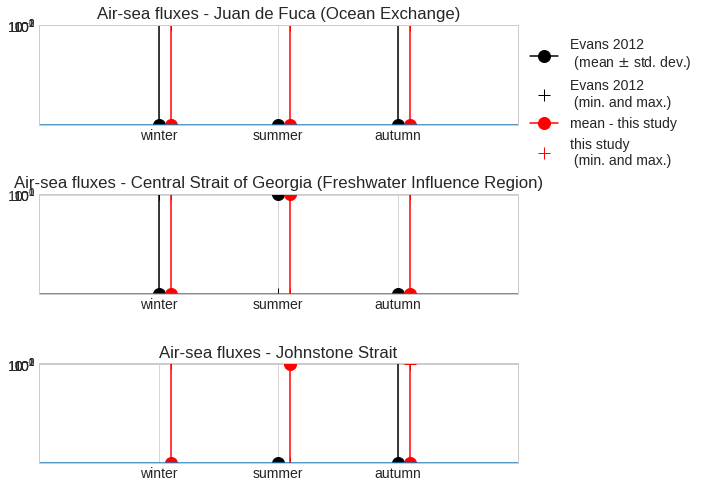

In [271]:
# plt.rcParams.update({'font.size': 14})
# font = {'family' : 'normal',
# 'weight' : 'bold',
# 'size'   : 14}
# plt.rcParams['lines.markersize'] = 12

# fact = 0.5
# fig, axs = plt.subplots(3,1, figsize=(20*fact, 14*fact), facecolor='w', edgecolor='k')\

# # BR_NS_S_nn

# #winter summer autumn
# axs = axs.ravel()
# axs[0].plot(1,JDF_W_mean,marker = 'o', color = 'k',label = 'Evans 2012 \n (mean $\pm$ std. dev.)' )
# axs[0].errorbar(1,JDF_W_mean,yerr = JDF_W_std, color = 'k',ecolor ='k' )
# axs[0].plot(1,JDF_W_min,marker = '+', color = 'k', linestyle = 'none', label = 'Evans 2012 \n (min. and max.)')
# axs[0].plot(1,JDF_W_max,marker = '+', color = 'k')

# axs[0].plot(1.1,BR_JH_W_avg,marker = 'o', color = 'r',label = 'mean - this study' )
# axs[0].errorbar(1.1,BR_JH_W_avg,yerr = BR_JH_W_std, color = 'r',ecolor ='r')
# axs[0].plot(1.1,BR_JH_W_min,marker = '+', color = 'r', linestyle = 'none', label = 'this study \n (min. and max.)')
# axs[0].plot(1.1,BR_JH_W_max,marker = '+', color = 'r')


# axs[0].plot(2,JDF_S_mean,marker = 'o', color = 'k')
# axs[0].errorbar(2,JDF_S_mean,yerr = JDF_S_std, color = 'k', ecolor = 'k')
# axs[0].plot(2,JDF_S_min,marker = '+', color = 'k')
# axs[0].plot(2,JDF_S_max,marker = '+', color = 'k')

# axs[0].plot(2.1,BR_JH_S_avg,marker = 'o', color = 'r')
# axs[0].errorbar(2.1,BR_JH_S_avg,yerr = BR_JH_S_std, color = 'r',ecolor ='r')
# axs[0].plot(2.1,BR_JH_S_min,marker = '+', color = 'r', linestyle = 'none')
# axs[0].plot(2.1,BR_JH_S_max,marker = '+', color = 'r')

# axs[0].plot(3,JDF_A_mean,marker = 'o', color = 'k')
# axs[0].errorbar(3,JDF_A_mean,yerr = JDF_A_std, color = 'k', ecolor = 'k')
# axs[0].plot(3,JDF_A_min,marker = '+', color = 'k')
# axs[0].plot(3,JDF_A_max,marker = '+', color = 'k')

# axs[0].plot(3.1,BR_JH_A_avg,marker = 'o', color = 'r')
# axs[0].errorbar(3.1,BR_JH_A_avg,yerr = BR_JH_A_std, color = 'r',ecolor ='r')
# axs[0].plot(3.1,BR_JH_A_min,marker = '+', color = 'r', linestyle = 'none')
# axs[0].plot(3.1,BR_JH_A_max,marker = '+', color = 'r')

# axs[0].set_title('Air-sea fluxes - Juan de Fuca (Ocean Exchange)')
# axs[0].legend(bbox_to_anchor = [1, 1])
# ######
# axs[1].plot(1,CS_W_mean,marker = 'o', color = 'k',label = 'Evans 2012 (mean $\pm$ std. dev.)' )
# axs[1].errorbar(1,CS_W_mean,yerr = CS_W_std, color = 'k',ecolor ='k' )
# axs[1].plot(1,CS_W_min,marker = '+', color = 'k', linestyle = 'none', label = 'Evans 2012 (min. and max.)')
# axs[1].plot(1,CS_W_max,marker = '+', color = 'k')

# axs[1].plot(1.1,BR_CS_W_avg,marker = 'o', color = 'r',label = 'mean - this study' )
# axs[1].errorbar(1.1,BR_CS_W_avg,yerr = BR_CS_W_std, color = 'r',ecolor ='r')
# axs[1].plot(1.1,BR_CS_W_min,marker = '+', color = 'r', linestyle = 'none', label = 'this study (min. and max.)')
# axs[1].plot(1.1,BR_CS_W_max,marker = '+', color = 'r')


# axs[1].plot(2,CS_S_mean,marker = 'o', color = 'k')
# axs[1].errorbar(2,CS_S_mean,yerr = CS_S_std, color = 'k', ecolor = 'k')
# axs[1].plot(2,CS_S_min,marker = '+', color = 'k')
# axs[1].plot(2,CS_S_max,marker = '+', color = 'k')

# axs[1].plot(2.1,BR_CS_S_avg,marker = 'o', color = 'r')
# axs[1].errorbar(2.1,BR_CS_S_avg,yerr = BR_CS_S_std, color = 'r',ecolor ='r')
# axs[1].plot(2.1,BR_CS_S_min,marker = '+', color = 'r', linestyle = 'none')
# axs[1].plot(2.1,BR_CS_S_max,marker = '+', color = 'r')

# axs[1].plot(3,CS_A_mean,marker = 'o', color = 'k')
# axs[1].errorbar(3,CS_A_mean,yerr = CS_A_std, color = 'k', ecolor = 'k')
# axs[1].plot(3,CS_A_min,marker = '+', color = 'k')
# axs[1].plot(3,CS_A_max,marker = '+', color = 'k')

# axs[1].plot(3.1,BR_CS_A_avg,marker = 'o', color = 'r')
# axs[1].errorbar(3.1,BR_CS_A_avg,yerr = BR_CS_A_std, color = 'r',ecolor ='r')
# axs[1].plot(3.1,BR_CS_A_min,marker = '+', color = 'r', linestyle = 'none')
# axs[1].plot(3.1,BR_CS_A_max,marker = '+', color = 'r')
# axs[1].set_title('Air-sea fluxes - Central Strait of Georgia (Freshwater Influence Region)')
# #####
# axs[2].plot(1,NS_W_mean,marker = 'o', color = 'k',label = 'Evans 2012 (mean $\pm$ std. dev.)' )
# axs[2].errorbar(1,NS_W_mean,yerr = NS_W_std, color = 'k',ecolor ='k' )
# axs[2].plot(1,NS_W_min,marker = '+', color = 'k', linestyle = 'none', label = 'Evans 2012 (min. and max.)')
# axs[2].plot(1,NS_W_max,marker = '+', color = 'k')

# axs[2].plot(1.1,BR_NS_W_avg,marker = 'o', color = 'r',label = 'mean - this study' )
# axs[2].errorbar(1.1,BR_NS_W_avg,yerr = BR_NS_W_std, color = 'r',ecolor ='r')
# axs[2].plot(1.1,BR_NS_W_min,marker = '+', color = 'r', linestyle = 'none', label = 'this study (min. and max.)')
# axs[2].plot(1.1,BR_NS_W_max,marker = '+', color = 'r')


# axs[2].plot(2,NS_S_mean,marker = 'o', color = 'k')
# axs[2].errorbar(2,NS_S_mean,yerr = NS_S_std, color = 'k', ecolor = 'k')
# axs[2].plot(2,NS_S_min,marker = '+', color = 'k')
# axs[2].plot(2,NS_S_max,marker = '+', color = 'k')

# axs[2].plot(2.1,BR_NS_S_avg,marker = 'o', color = 'r')
# axs[2].errorbar(2.1,BR_NS_S_avg,yerr = BR_NS_S_std, color = 'r',ecolor ='r')
# axs[2].plot(2.1,BR_NS_S_min,marker = '+', color = 'r', linestyle = 'none')
# axs[2].plot(2.1,BR_NS_S_max,marker = '+', color = 'r')

# axs[2].plot(3,NS_A_mean,marker = 'o', color = 'k')
# axs[2].errorbar(3,NS_A_mean,yerr = NS_A_std, color = 'k', ecolor = 'k')
# axs[2].plot(3,NS_A_min,marker = '+', color = 'k')
# axs[2].plot(3,NS_A_max,marker = '+', color = 'k')

# axs[2].plot(3.1,BR_NS_A_avg,marker = 'o', color = 'r')
# axs[2].errorbar(3.1,BR_NS_A_avg,yerr = BR_NS_A_std, color = 'r',ecolor ='r')
# axs[2].plot(3.1,BR_NS_A_min,marker = '+', color = 'r', linestyle = 'none')
# axs[2].plot(3.1,BR_NS_A_max,marker = '+', color = 'r')
# axs[2].set_title('Air-sea fluxes - Johnstone Strait')

# # axs[2].plot(2.1,np.mean(BR_NS_S_nn),marker = 'o', color = 'k')

# for i in range(0,3):
#     axs[i].set_xlim([0,4])
#     axs[i].set_ylim([-225,55])
#     axs[i].set_xticks([1,2,3])
#     axs[i].set_xticklabels(['winter','summer','autumn'])
#     axs[i].axhline(y=0)
#     #plt.errorbar(n, y, yerr = yerror, ecolor = 'k', capsize = 5)
#     axs[i].set_yscale('log')
# plt.tight_layout()